In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [ ]:
# Load dataset

df = pd.read_csv("dataset.csv")

# Drop unnamed columns
df.drop(
    df.columns[df.columns.str.contains("unnamed", case=False)], axis=1, inplace=True
)  # drop unnamed column
df.dropna(inplace=True)  # drop rows with null values

# Convert 'explicit' boolean to integer (0/1)
df["explicit"] = df["explicit"].astype(int)

# One-hot encode categorical features
df = pd.get_dummies(
    df, columns=["key", "time_signature", "track_genre"], drop_first=True
)

# Make valence binary for classification
df["valence"] = df["valence"].astype("category")
df["valence"] = df["valence"].map(
    lambda x: 0 if x < 0.5 else 1
)  # sets valence to 0 if sad, 1 if happy

# Drop unneeded features and make valence our target feature
X = df.drop(["track_id", "artists", "album_name", "track_name", "valence", "duration_ms"], axis=1)
y = df["valence"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [30]:
# Base estimator (Decision Tree with max depth to prevent overfitting)
base_tree = DecisionTreeClassifier(criterion="entropy", max_depth=5)

# Boosted model (C5.0-like)
model = AdaBoostClassifier(estimator=base_tree, n_estimators=50, learning_rate=1.0)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)

In [31]:
# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Accuracy: 0.7620

Confusion Matrix:
 [[14444  4127]
 [ 4012 11617]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78     18571
           1       0.74      0.74      0.74     15629

    accuracy                           0.76     34200
   macro avg       0.76      0.76      0.76     34200
weighted avg       0.76      0.76      0.76     34200



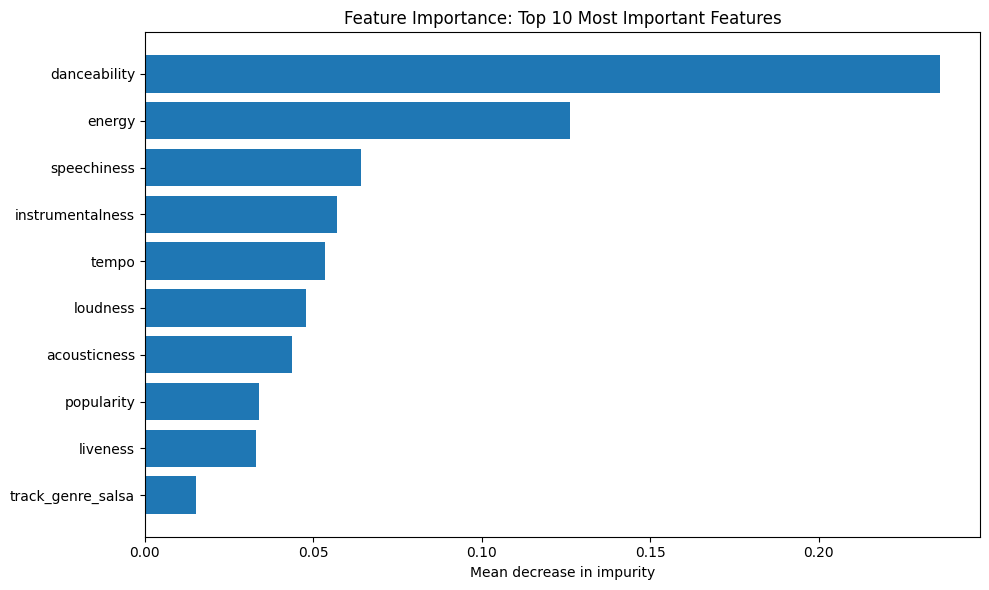

In [34]:
# Number of top features to display
top_n = 10

# Get feature importances and sort them
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # Descending order

# Select top N
top_indices = indices[:top_n]
top_features = X.columns[top_indices]
top_importances = importances[top_indices]


# Plot
plt.figure(figsize=(10, 6))
plt.barh(
    range(top_n), top_importances[::-1], align="center"
)  # Reverse for best-first top-down
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel("Mean decrease in impurity")
plt.title(f"Feature Importance: Top {top_n} Most Important Features")
plt.tight_layout()
plt.show()

[Text(0.5, 0.9166666666666666, 'danceability <= 0.518\nentropy = 0.995\nsamples = 100.0%\nvalue = [0.542, 0.458]\nclass = Sad'),
 Text(0.25, 0.75, 'danceability <= 0.332\nentropy = 0.786\nsamples = 36.3%\nvalue = [0.766, 0.234]\nclass = Sad'),
 Text(0.375, 0.8333333333333333, 'True  '),
 Text(0.125, 0.5833333333333334, 'energy <= 0.426\nentropy = 0.416\nsamples = 10.2%\nvalue = [0.916, 0.084]\nclass = Sad'),
 Text(0.0625, 0.4166666666666667, 'danceability <= 0.267\nentropy = 0.148\nsamples = 4.5%\nvalue = [0.979, 0.021]\nclass = Sad'),
 Text(0.03125, 0.25, 'tempo <= 152.101\nentropy = 0.059\nsamples = 2.9%\nvalue = [0.993, 0.007]\nclass = Sad'),
 Text(0.015625, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.046875, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.09375, 0.25, 'track_genre_classical <= 0.5\nentropy = 0.277\nsamples = 1.6%\nvalue = [0.952, 0.048]\nclass = Sad'),
 Text(0.078125, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.109375, 0.08333333333333333, '\n  (...)  \n'),
 T

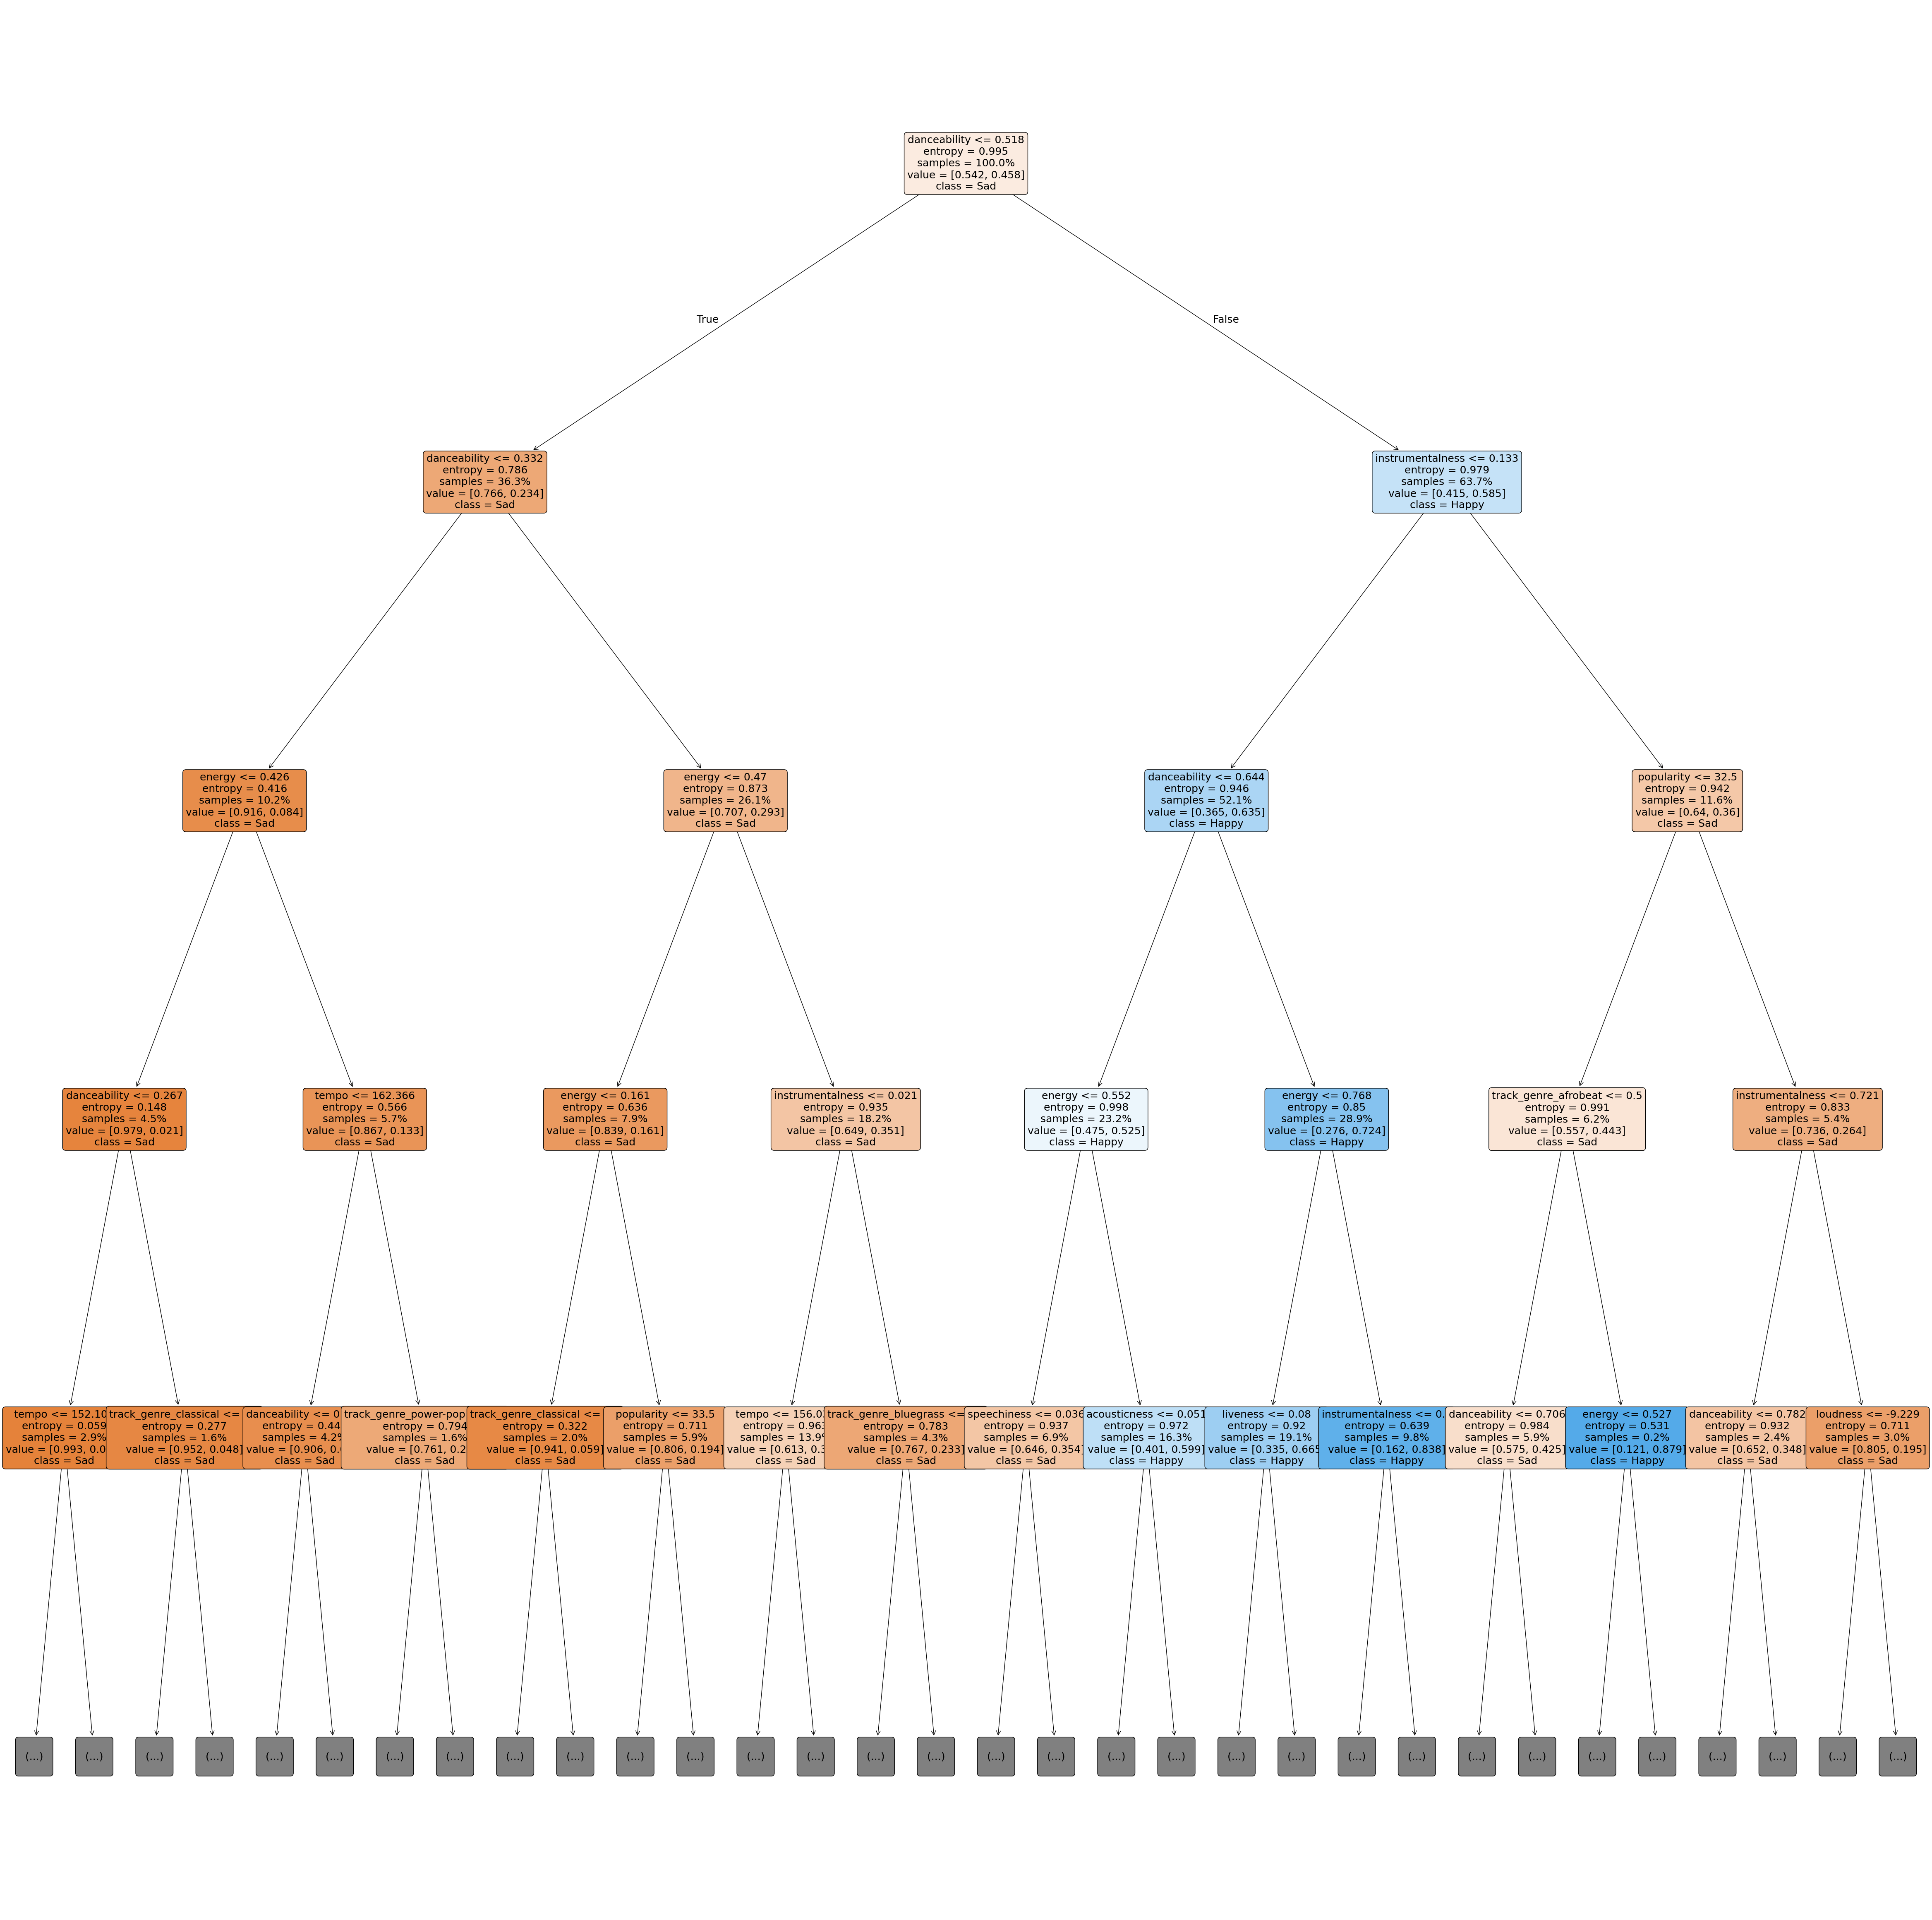

In [35]:
single_tree = model.estimators_[0]
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(60, 60))
plot_tree(
    single_tree,
    max_depth=4,
    fontsize=18,
    filled=True,
    feature_names=X.columns,
    class_names=["Sad", "Happy"],
    rounded=True,
    proportion=True
)

In [36]:
test_actual = X_test  # Copy attr_test
test_actual["target_pred"] = y_pred  # Create new column for prediction values
test_actual["test_actual"] = y_test  # Create new column for actual values
# test_actual.head()  # Show table

false_positives = test_actual[
    (test_actual["target_pred"] == 1) & (test_actual["test_actual"] == 0)
]

false_negatives = test_actual[
    (test_actual["target_pred"] == 0) & (test_actual["test_actual"] == 1)
]

true_positives = test_actual[
    (test_actual["target_pred"] == 1) & (test_actual["test_actual"] == 1)
]

true_negatives = test_actual[
    (test_actual["target_pred"] == 0) & (test_actual["test_actual"] == 0)
]

print(false_positives)
print(false_negatives)

        popularity  explicit  danceability  energy  loudness  mode  \
71306           61         0         0.645   0.688    -4.749     1   
113386          39         0         0.572   0.786    -3.628     1   
60735           19         0         0.911   0.616   -12.460     1   
3241             0         0         0.416   0.964    -2.967     1   
37587           48         0         0.553   0.732    -5.206     0   
...            ...       ...           ...     ...       ...   ...   
88700           82         0         0.856   0.618    -4.892     1   
91678            0         0         0.684   0.491    -7.655     1   
84334           56         0         0.653   0.472   -14.797     1   
29560            0         0         0.486   0.933    -2.758     1   
53782           62         1         0.687   0.915    -1.342     1   

        speechiness  acousticness  instrumentalness  liveness  ...  \
71306        0.0341      0.010700          0.000000    0.1860  ...   
113386       0.0442

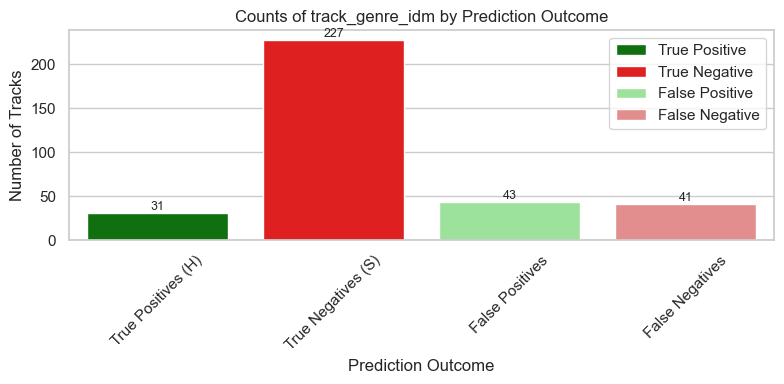

True Positives (H)     31
True Negatives (S)    227
False Positives        43
False Negatives        41
Name: track_genre_idm, dtype: int64


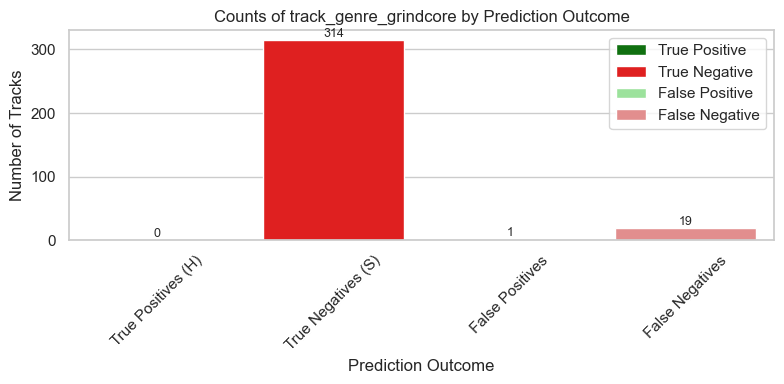

True Positives (H)      0
True Negatives (S)    314
False Positives         1
False Negatives        19
Name: track_genre_grindcore, dtype: int64


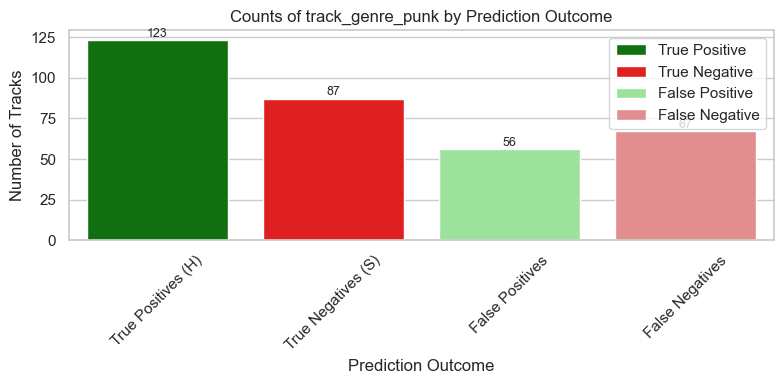

True Positives (H)    123
True Negatives (S)     87
False Positives        56
False Negatives        67
Name: track_genre_punk, dtype: int64


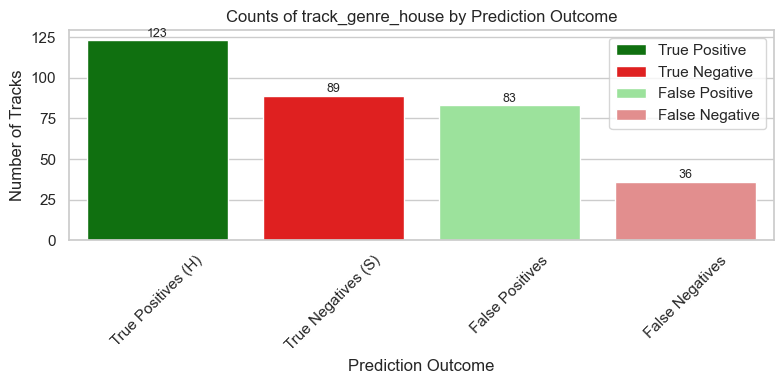

True Positives (H)    123
True Negatives (S)     89
False Positives        83
False Negatives        36
Name: track_genre_house, dtype: int64


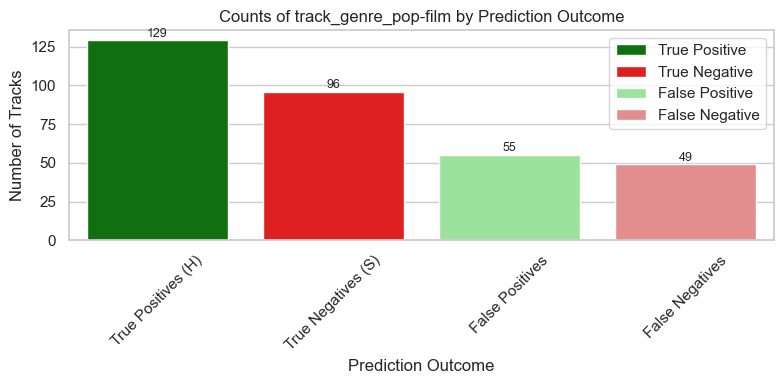

True Positives (H)    129
True Negatives (S)     96
False Positives        55
False Negatives        49
Name: track_genre_pop-film, dtype: int64


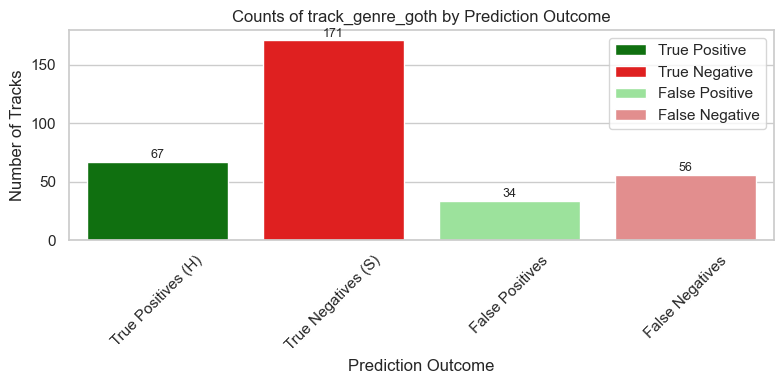

True Positives (H)     67
True Negatives (S)    171
False Positives        34
False Negatives        56
Name: track_genre_goth, dtype: int64


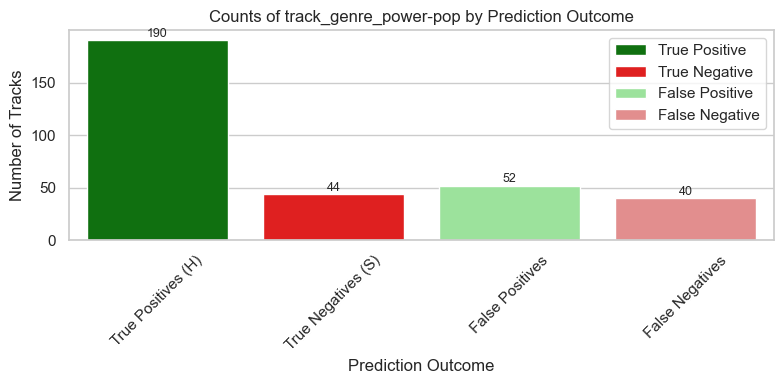

True Positives (H)    190
True Negatives (S)     44
False Positives        52
False Negatives        40
Name: track_genre_power-pop, dtype: int64


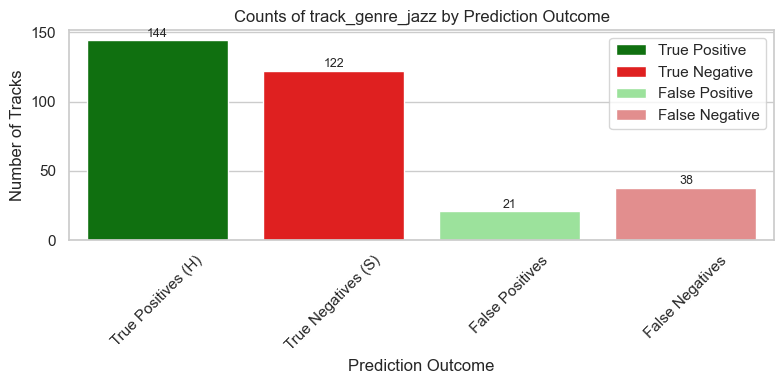

True Positives (H)    144
True Negatives (S)    122
False Positives        21
False Negatives        38
Name: track_genre_jazz, dtype: int64


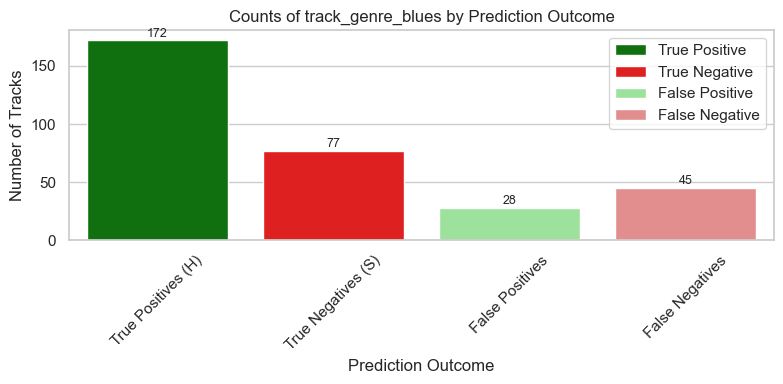

True Positives (H)    172
True Negatives (S)     77
False Positives        28
False Negatives        45
Name: track_genre_blues, dtype: int64


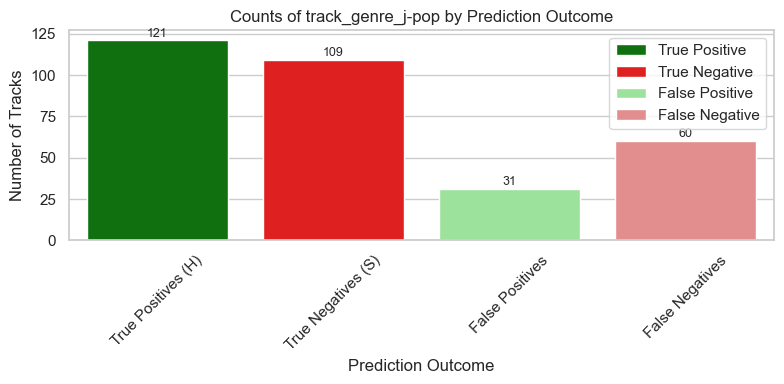

True Positives (H)    121
True Negatives (S)    109
False Positives        31
False Negatives        60
Name: track_genre_j-pop, dtype: int64


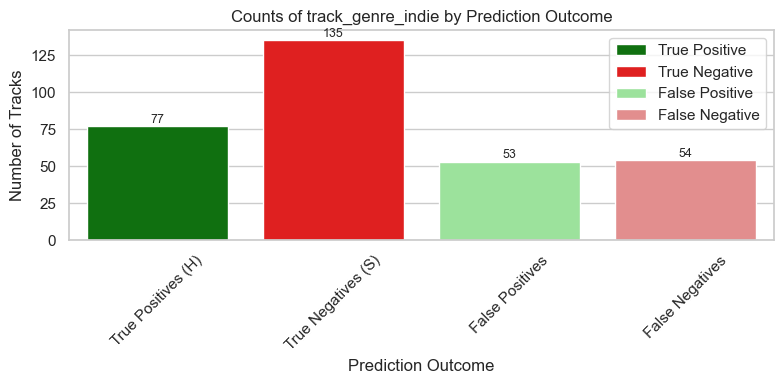

True Positives (H)     77
True Negatives (S)    135
False Positives        53
False Negatives        54
Name: track_genre_indie, dtype: int64


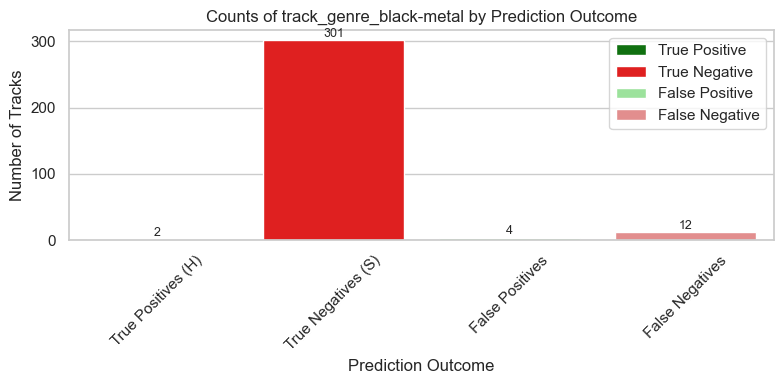

True Positives (H)      2
True Negatives (S)    301
False Positives         4
False Negatives        12
Name: track_genre_black-metal, dtype: int64


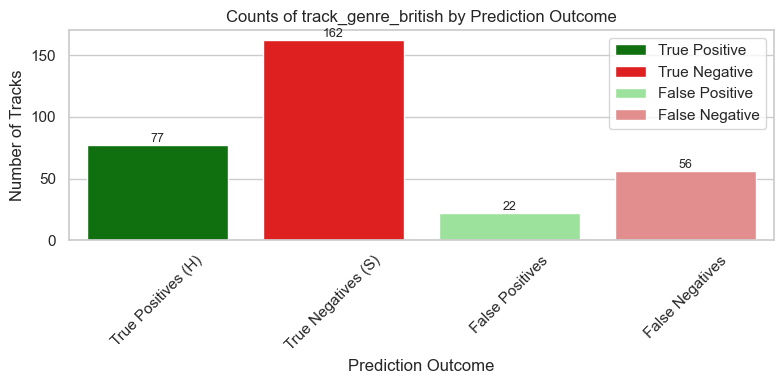

True Positives (H)     77
True Negatives (S)    162
False Positives        22
False Negatives        56
Name: track_genre_british, dtype: int64


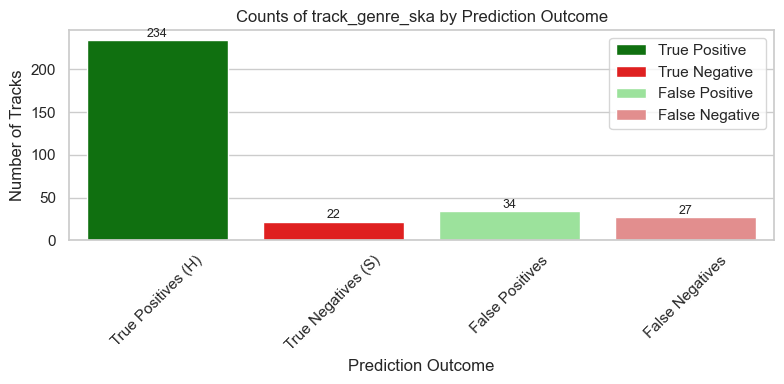

True Positives (H)    234
True Negatives (S)     22
False Positives        34
False Negatives        27
Name: track_genre_ska, dtype: int64


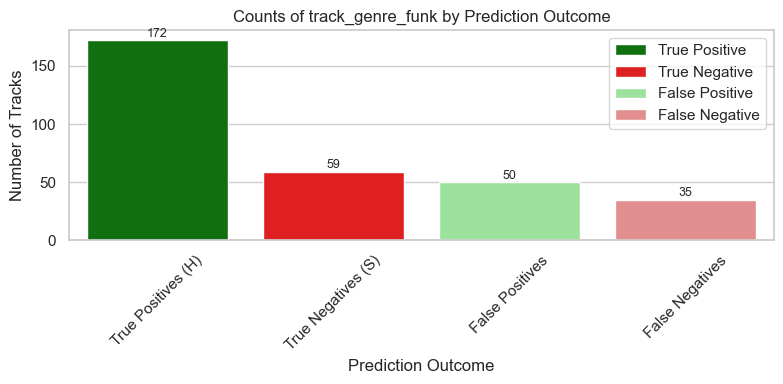

True Positives (H)    172
True Negatives (S)     59
False Positives        50
False Negatives        35
Name: track_genre_funk, dtype: int64


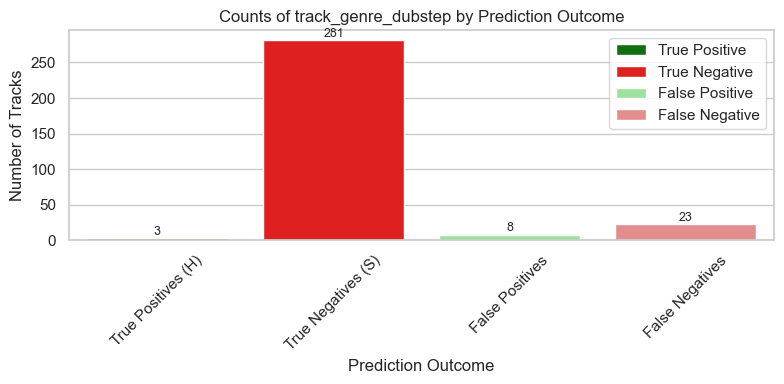

True Positives (H)      3
True Negatives (S)    281
False Positives         8
False Negatives        23
Name: track_genre_dubstep, dtype: int64


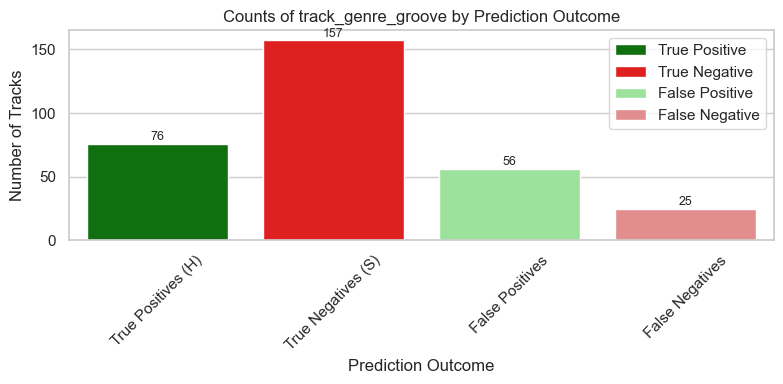

True Positives (H)     76
True Negatives (S)    157
False Positives        56
False Negatives        25
Name: track_genre_groove, dtype: int64


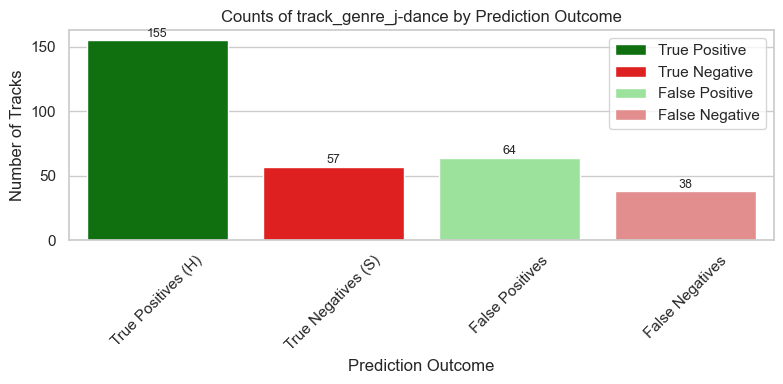

True Positives (H)    155
True Negatives (S)     57
False Positives        64
False Negatives        38
Name: track_genre_j-dance, dtype: int64


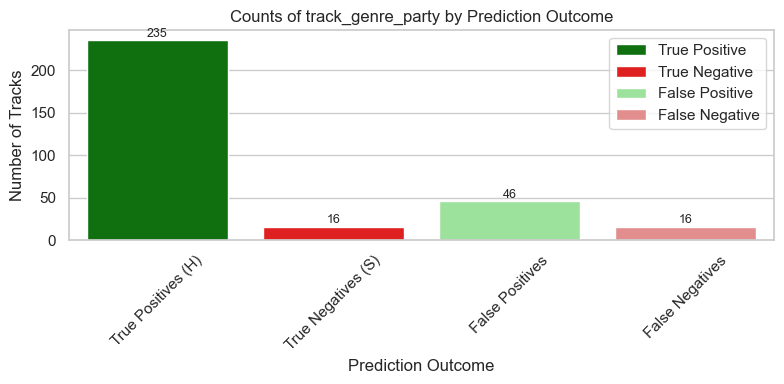

True Positives (H)    235
True Negatives (S)     16
False Positives        46
False Negatives        16
Name: track_genre_party, dtype: int64


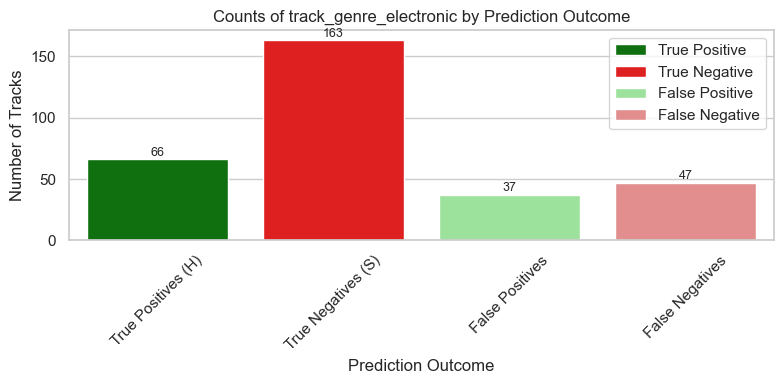

True Positives (H)     66
True Negatives (S)    163
False Positives        37
False Negatives        47
Name: track_genre_electronic, dtype: int64


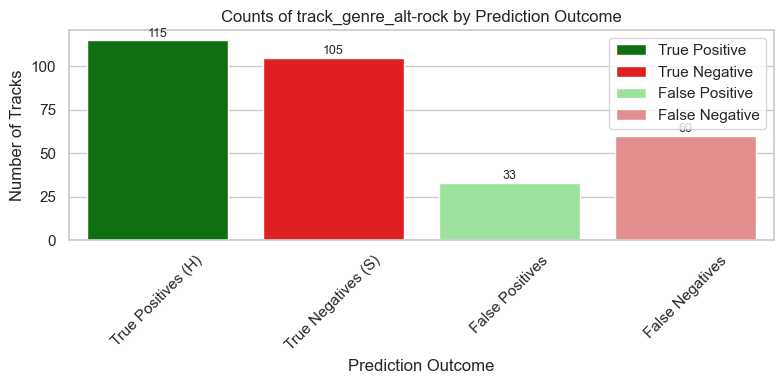

True Positives (H)    115
True Negatives (S)    105
False Positives        33
False Negatives        60
Name: track_genre_alt-rock, dtype: int64


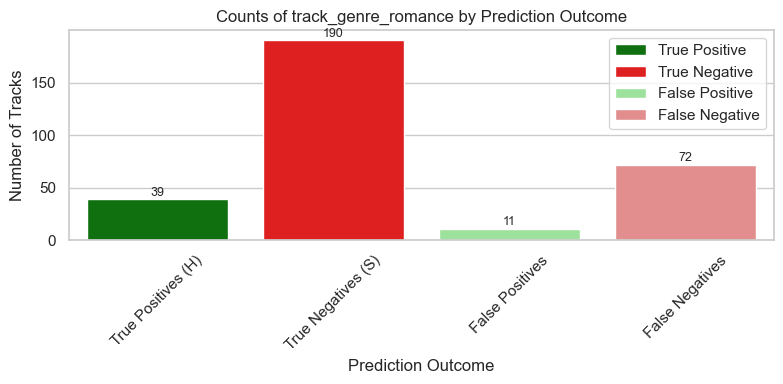

True Positives (H)     39
True Negatives (S)    190
False Positives        11
False Negatives        72
Name: track_genre_romance, dtype: int64


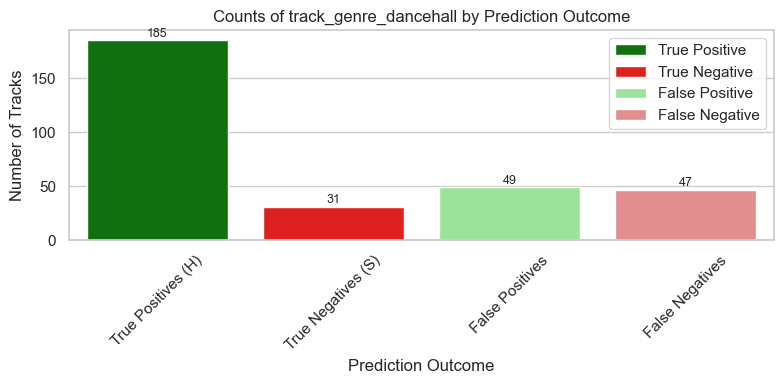

True Positives (H)    185
True Negatives (S)     31
False Positives        49
False Negatives        47
Name: track_genre_dancehall, dtype: int64


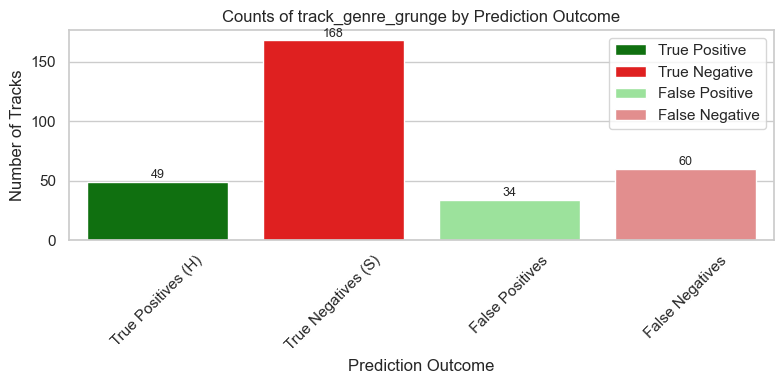

True Positives (H)     49
True Negatives (S)    168
False Positives        34
False Negatives        60
Name: track_genre_grunge, dtype: int64


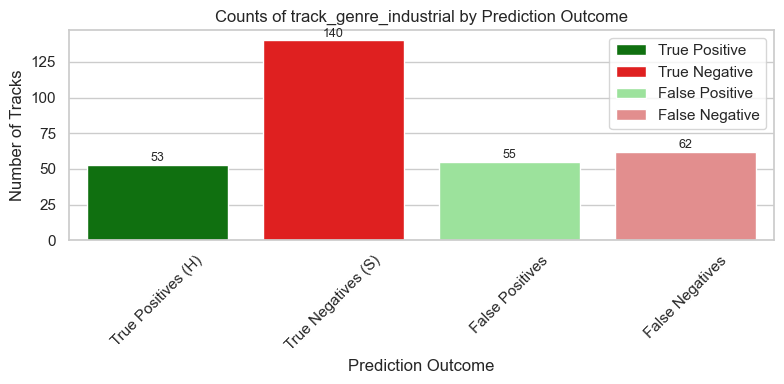

True Positives (H)     53
True Negatives (S)    140
False Positives        55
False Negatives        62
Name: track_genre_industrial, dtype: int64


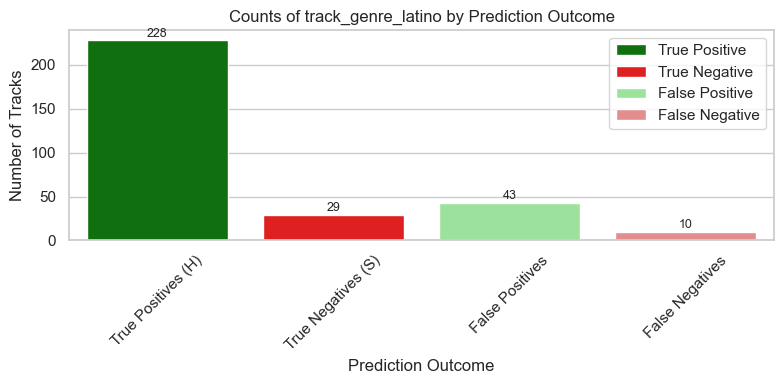

True Positives (H)    228
True Negatives (S)     29
False Positives        43
False Negatives        10
Name: track_genre_latino, dtype: int64


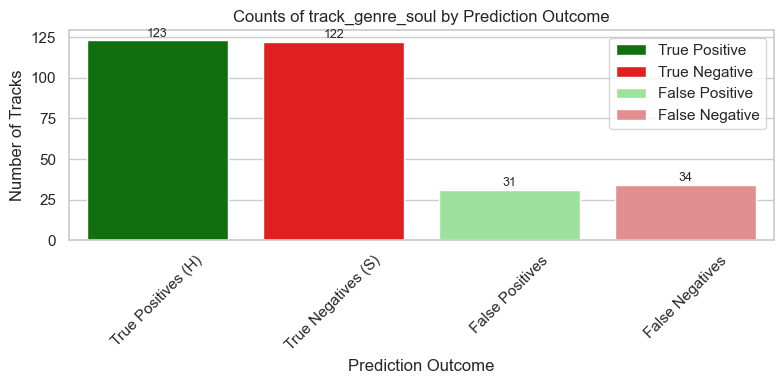

True Positives (H)    123
True Negatives (S)    122
False Positives        31
False Negatives        34
Name: track_genre_soul, dtype: int64


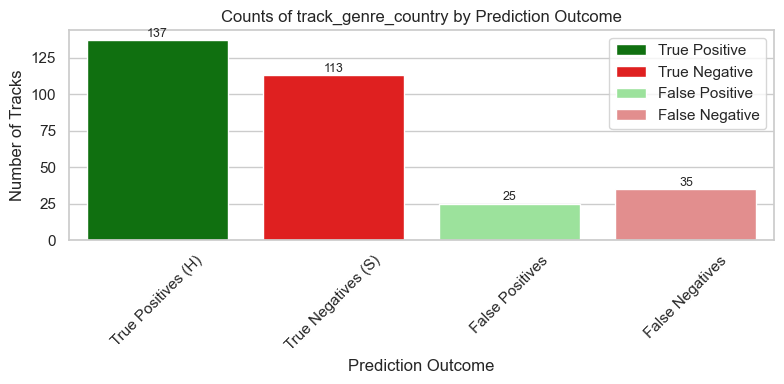

True Positives (H)    137
True Negatives (S)    113
False Positives        25
False Negatives        35
Name: track_genre_country, dtype: int64


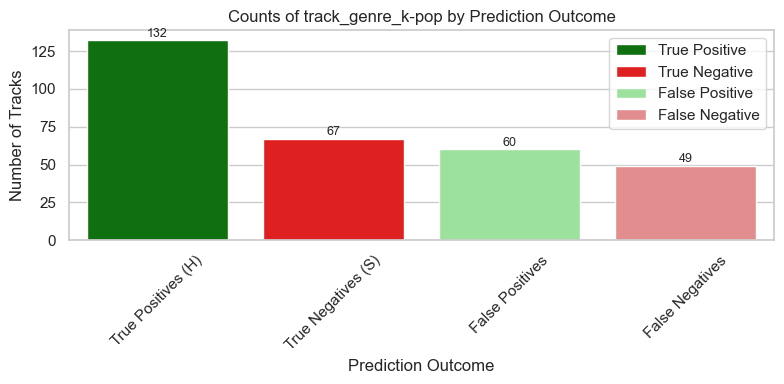

True Positives (H)    132
True Negatives (S)     67
False Positives        60
False Negatives        49
Name: track_genre_k-pop, dtype: int64


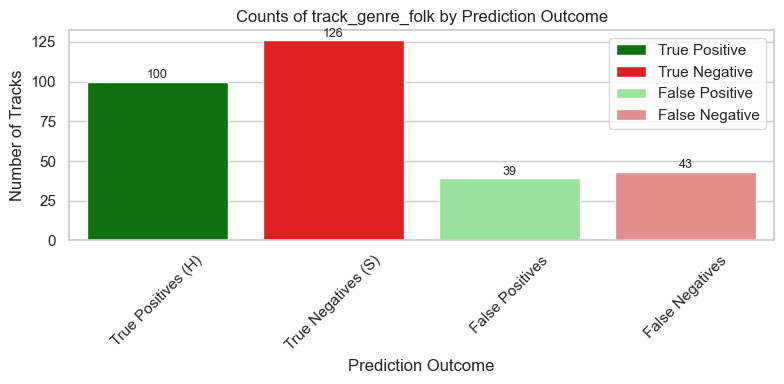

True Positives (H)    100
True Negatives (S)    126
False Positives        39
False Negatives        43
Name: track_genre_folk, dtype: int64


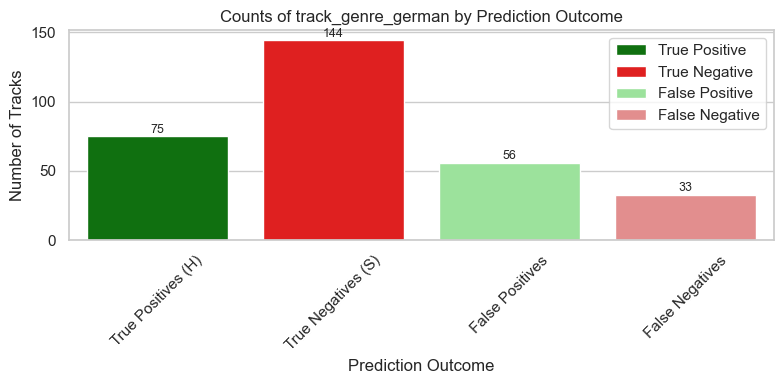

True Positives (H)     75
True Negatives (S)    144
False Positives        56
False Negatives        33
Name: track_genre_german, dtype: int64


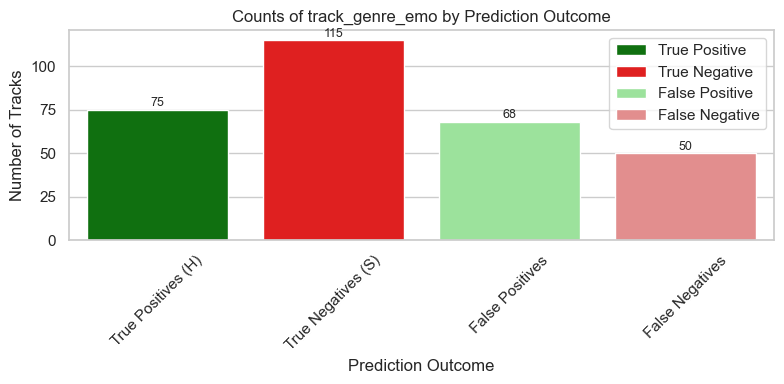

True Positives (H)     75
True Negatives (S)    115
False Positives        68
False Negatives        50
Name: track_genre_emo, dtype: int64


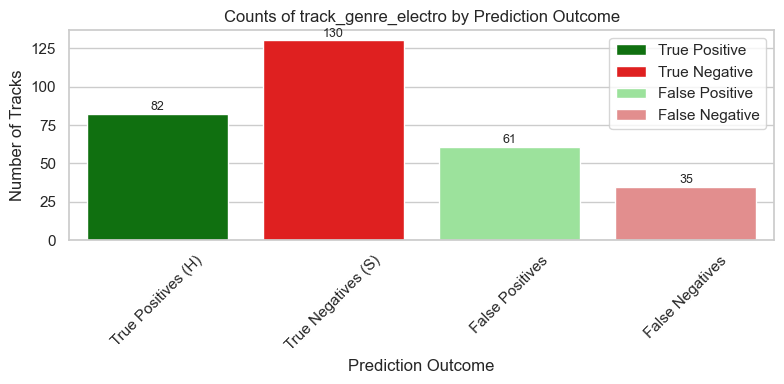

True Positives (H)     82
True Negatives (S)    130
False Positives        61
False Negatives        35
Name: track_genre_electro, dtype: int64


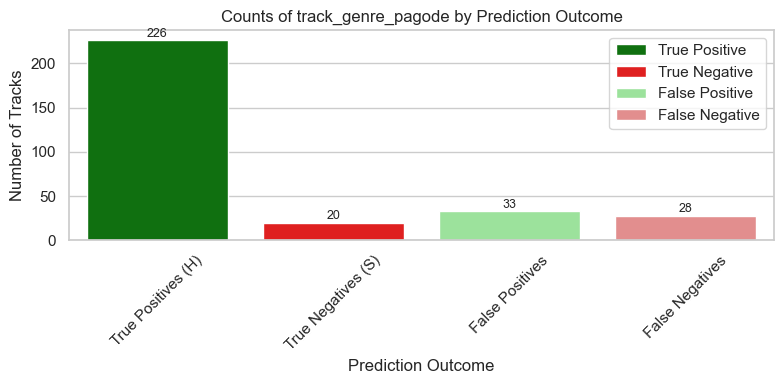

True Positives (H)    226
True Negatives (S)     20
False Positives        33
False Negatives        28
Name: track_genre_pagode, dtype: int64


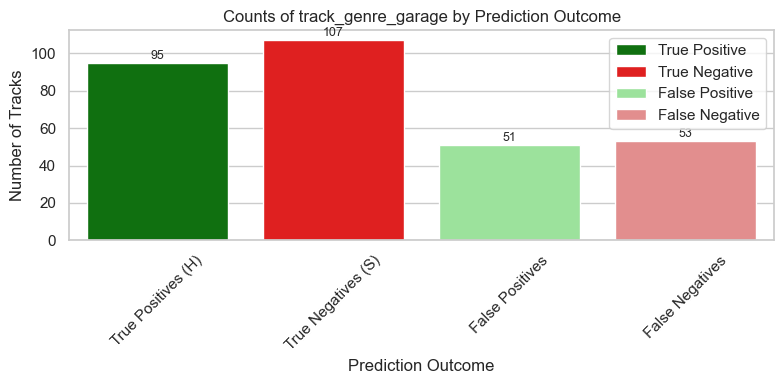

True Positives (H)     95
True Negatives (S)    107
False Positives        51
False Negatives        53
Name: track_genre_garage, dtype: int64


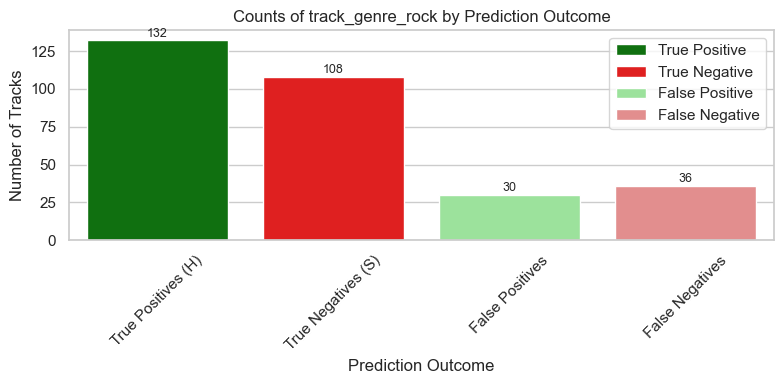

True Positives (H)    132
True Negatives (S)    108
False Positives        30
False Negatives        36
Name: track_genre_rock, dtype: int64


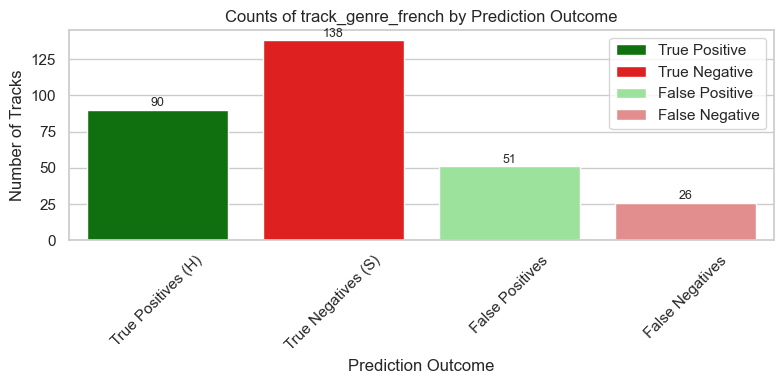

True Positives (H)     90
True Negatives (S)    138
False Positives        51
False Negatives        26
Name: track_genre_french, dtype: int64


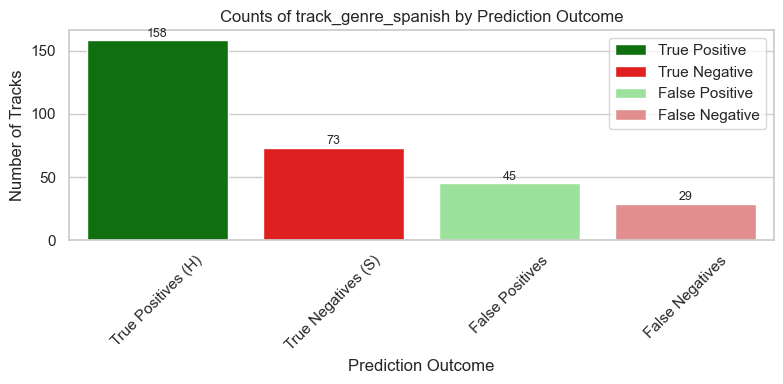

True Positives (H)    158
True Negatives (S)     73
False Positives        45
False Negatives        29
Name: track_genre_spanish, dtype: int64


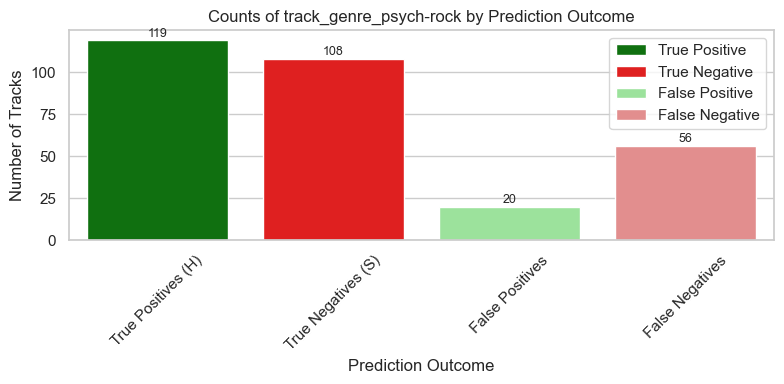

True Positives (H)    119
True Negatives (S)    108
False Positives        20
False Negatives        56
Name: track_genre_psych-rock, dtype: int64


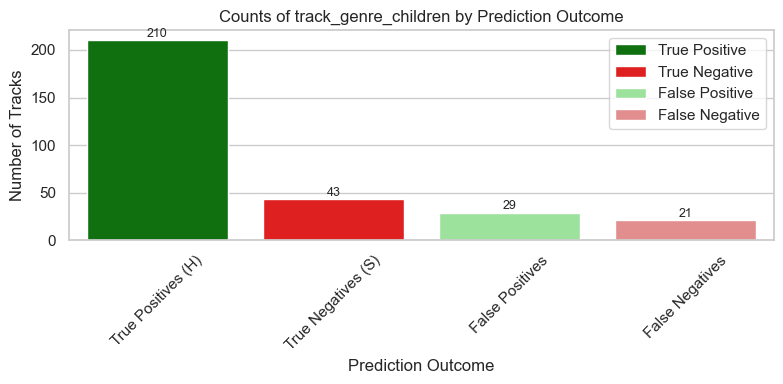

True Positives (H)    210
True Negatives (S)     43
False Positives        29
False Negatives        21
Name: track_genre_children, dtype: int64


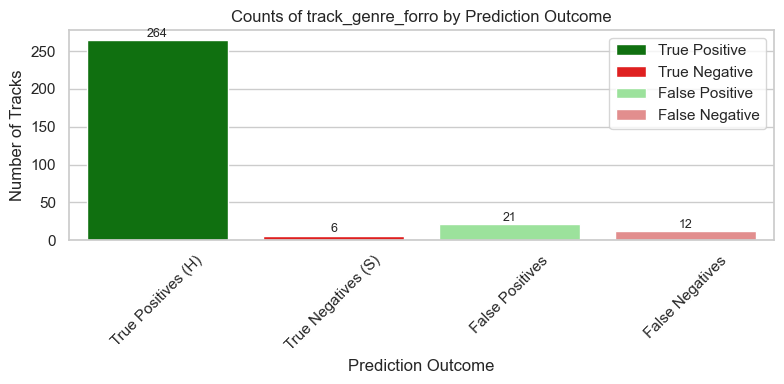

True Positives (H)    264
True Negatives (S)      6
False Positives        21
False Negatives        12
Name: track_genre_forro, dtype: int64


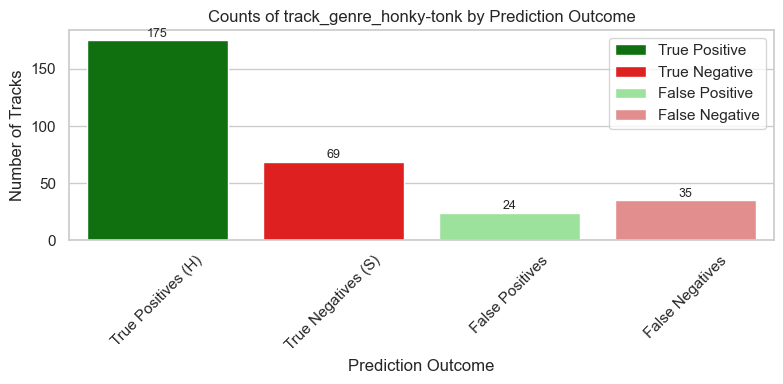

True Positives (H)    175
True Negatives (S)     69
False Positives        24
False Negatives        35
Name: track_genre_honky-tonk, dtype: int64


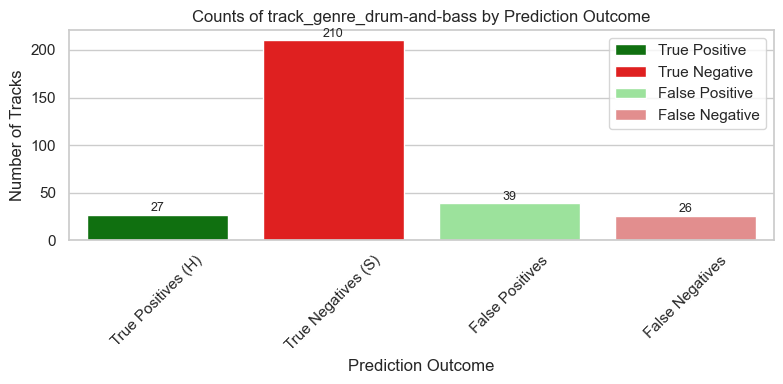

True Positives (H)     27
True Negatives (S)    210
False Positives        39
False Negatives        26
Name: track_genre_drum-and-bass, dtype: int64


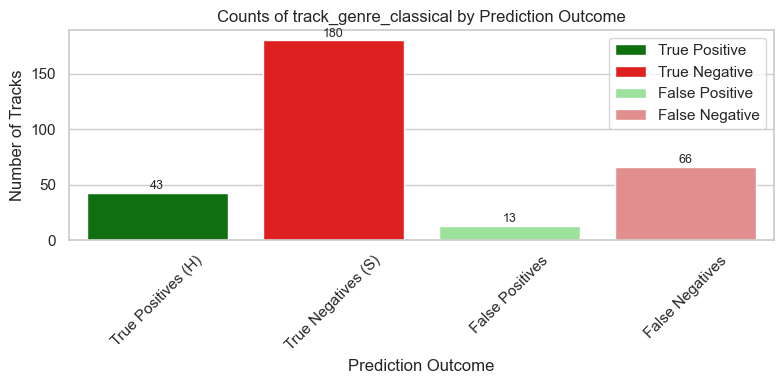

True Positives (H)     43
True Negatives (S)    180
False Positives        13
False Negatives        66
Name: track_genre_classical, dtype: int64


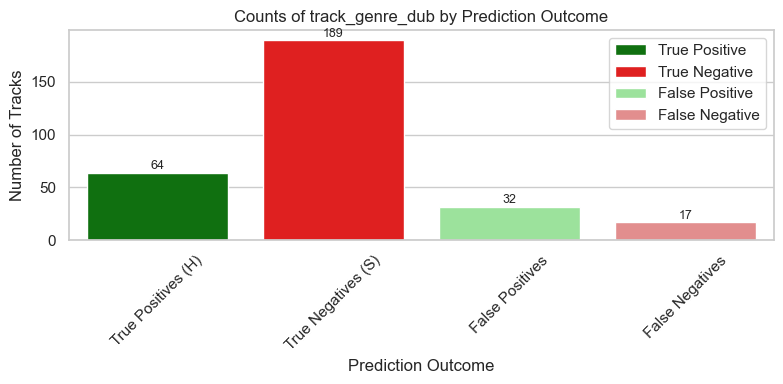

True Positives (H)     64
True Negatives (S)    189
False Positives        32
False Negatives        17
Name: track_genre_dub, dtype: int64


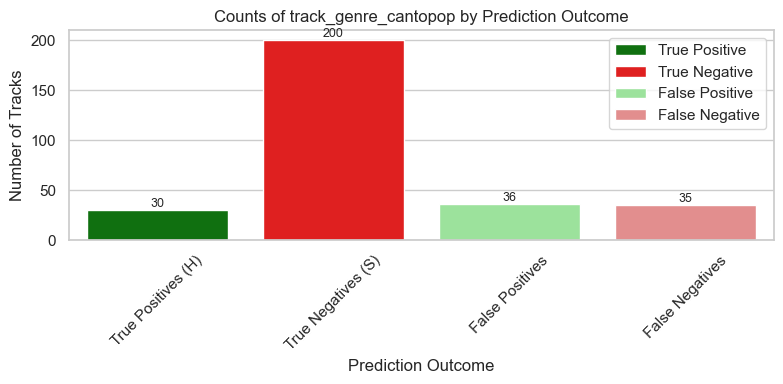

True Positives (H)     30
True Negatives (S)    200
False Positives        36
False Negatives        35
Name: track_genre_cantopop, dtype: int64


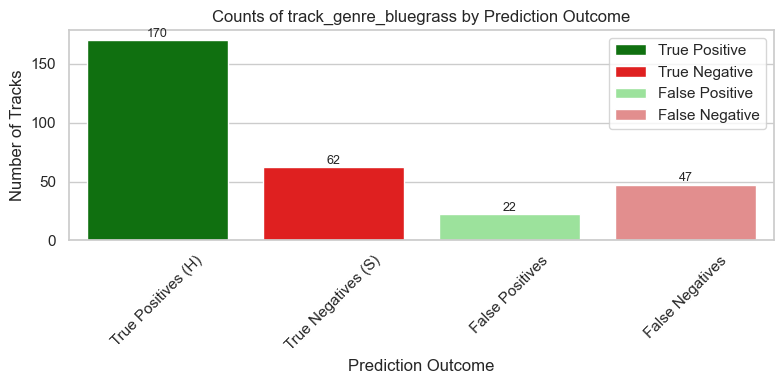

True Positives (H)    170
True Negatives (S)     62
False Positives        22
False Negatives        47
Name: track_genre_bluegrass, dtype: int64


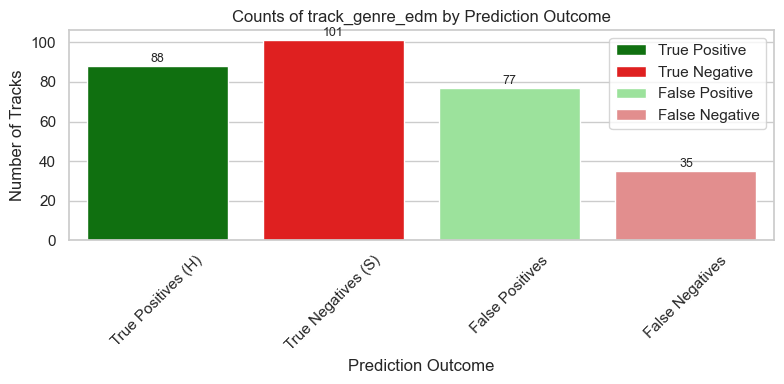

True Positives (H)     88
True Negatives (S)    101
False Positives        77
False Negatives        35
Name: track_genre_edm, dtype: int64


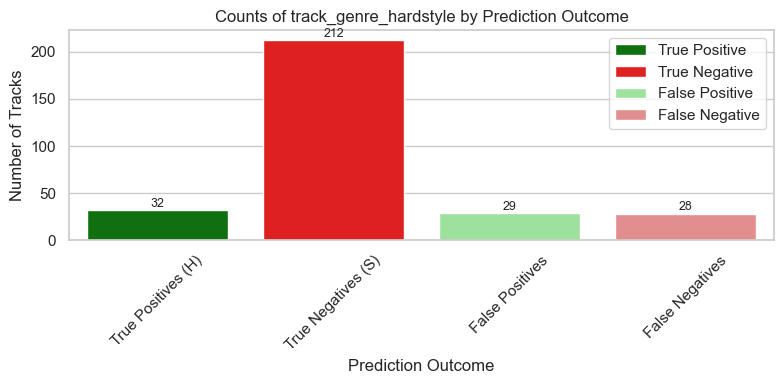

True Positives (H)     32
True Negatives (S)    212
False Positives        29
False Negatives        28
Name: track_genre_hardstyle, dtype: int64


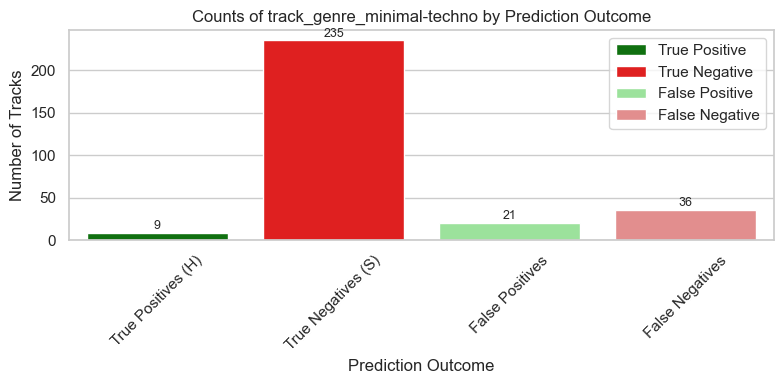

True Positives (H)      9
True Negatives (S)    235
False Positives        21
False Negatives        36
Name: track_genre_minimal-techno, dtype: int64


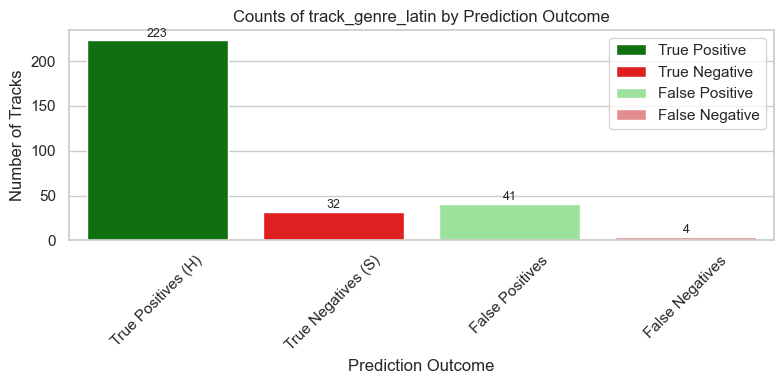

True Positives (H)    223
True Negatives (S)     32
False Positives        41
False Negatives         4
Name: track_genre_latin, dtype: int64


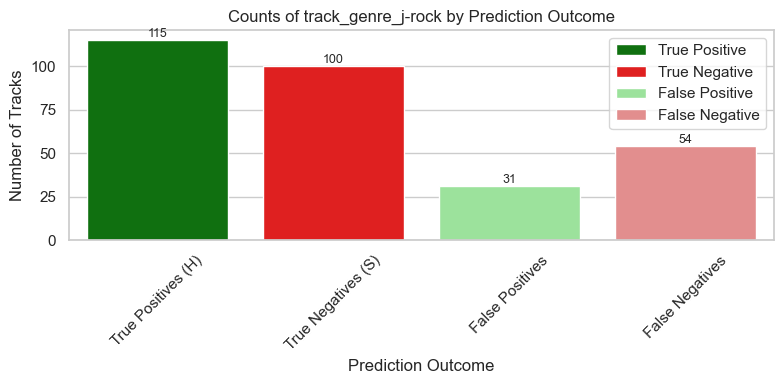

True Positives (H)    115
True Negatives (S)    100
False Positives        31
False Negatives        54
Name: track_genre_j-rock, dtype: int64


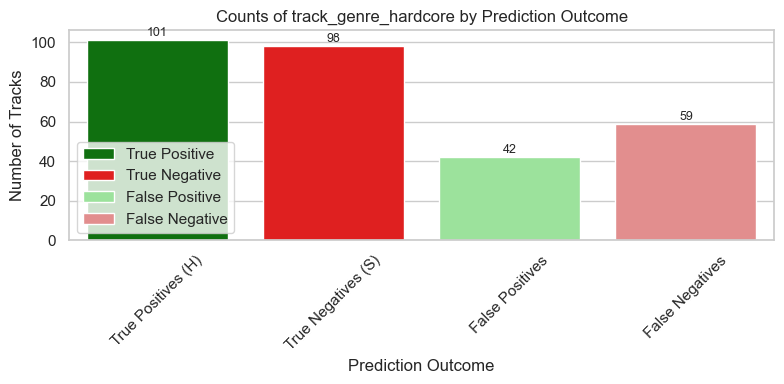

True Positives (H)    101
True Negatives (S)     98
False Positives        42
False Negatives        59
Name: track_genre_hardcore, dtype: int64


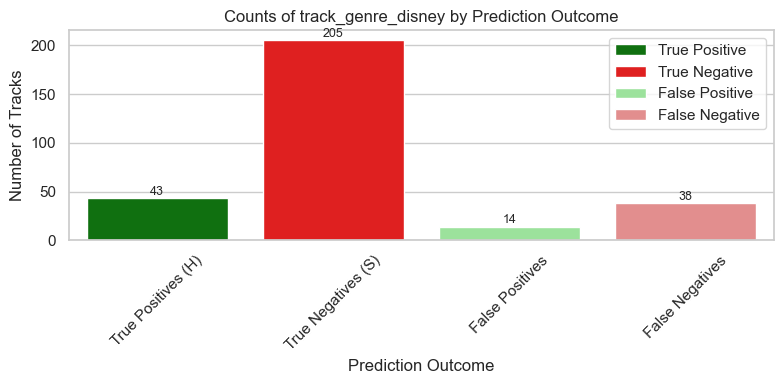

True Positives (H)     43
True Negatives (S)    205
False Positives        14
False Negatives        38
Name: track_genre_disney, dtype: int64


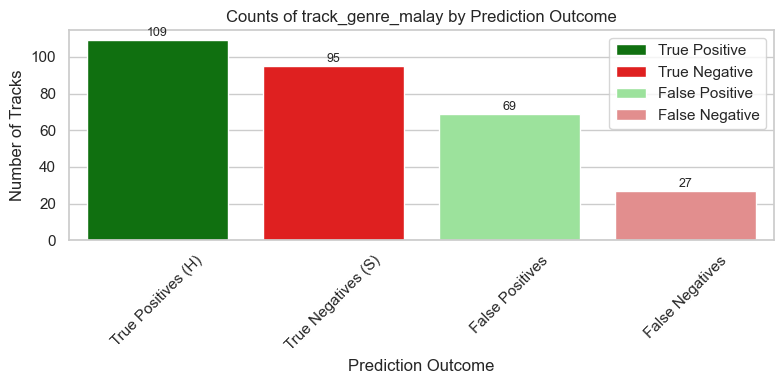

True Positives (H)    109
True Negatives (S)     95
False Positives        69
False Negatives        27
Name: track_genre_malay, dtype: int64


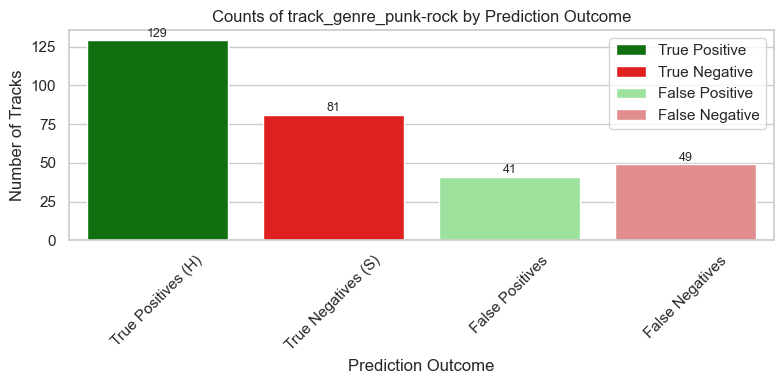

True Positives (H)    129
True Negatives (S)     81
False Positives        41
False Negatives        49
Name: track_genre_punk-rock, dtype: int64


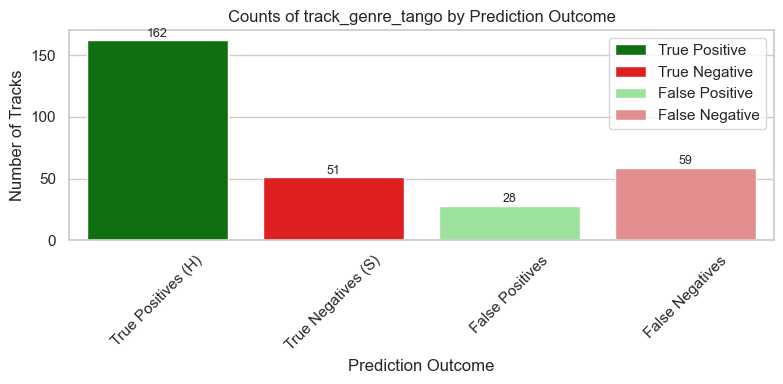

True Positives (H)    162
True Negatives (S)     51
False Positives        28
False Negatives        59
Name: track_genre_tango, dtype: int64


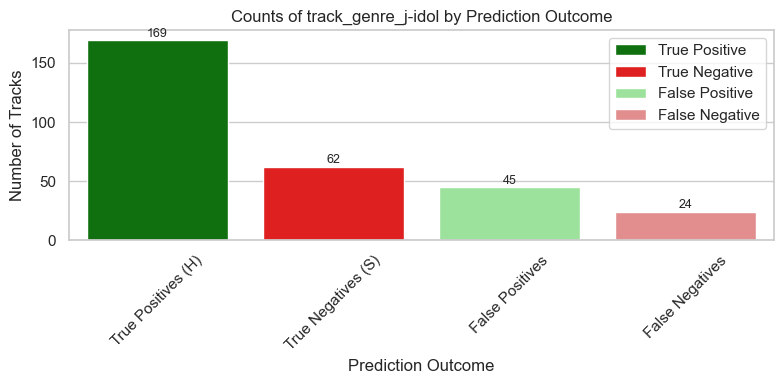

True Positives (H)    169
True Negatives (S)     62
False Positives        45
False Negatives        24
Name: track_genre_j-idol, dtype: int64


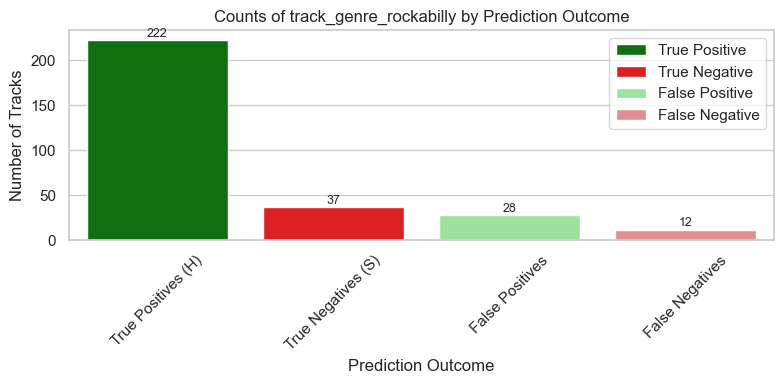

True Positives (H)    222
True Negatives (S)     37
False Positives        28
False Negatives        12
Name: track_genre_rockabilly, dtype: int64


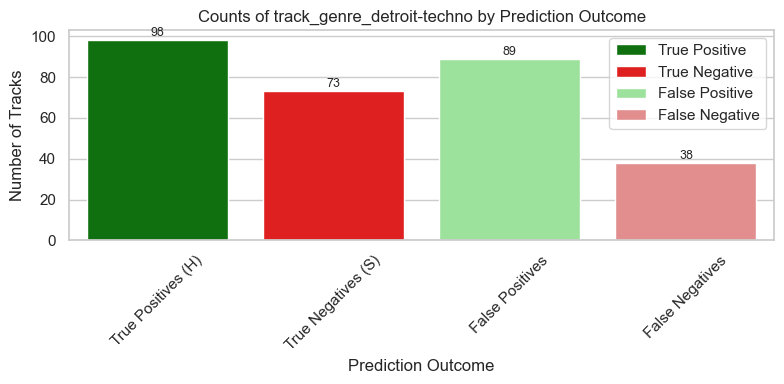

True Positives (H)    98
True Negatives (S)    73
False Positives       89
False Negatives       38
Name: track_genre_detroit-techno, dtype: int64


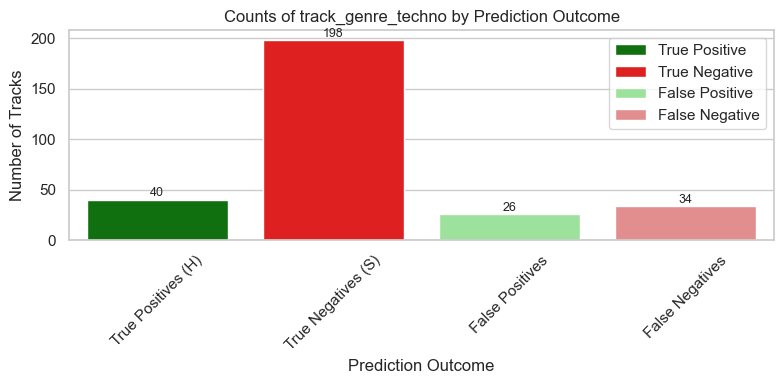

True Positives (H)     40
True Negatives (S)    198
False Positives        26
False Negatives        34
Name: track_genre_techno, dtype: int64


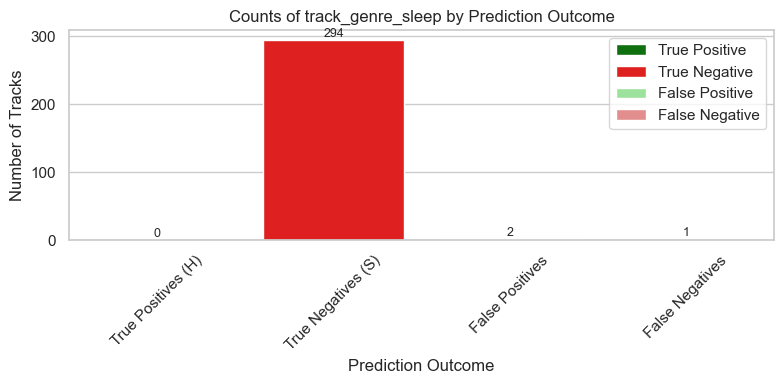

True Positives (H)      0
True Negatives (S)    294
False Positives         2
False Negatives         1
Name: track_genre_sleep, dtype: int64


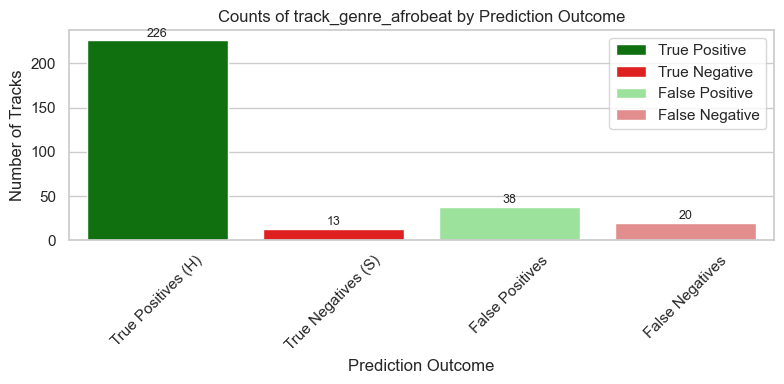

True Positives (H)    226
True Negatives (S)     13
False Positives        38
False Negatives        20
Name: track_genre_afrobeat, dtype: int64


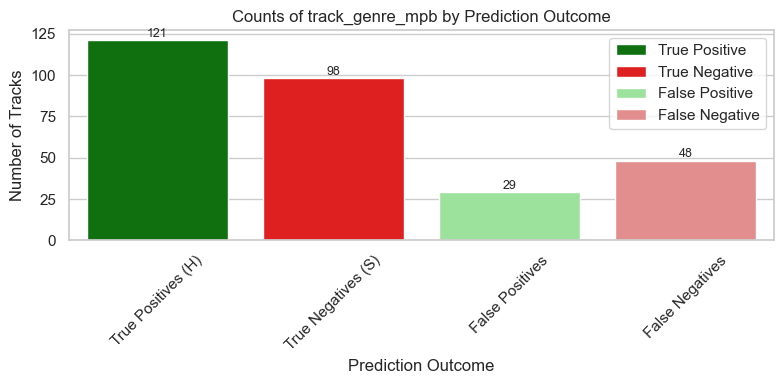

True Positives (H)    121
True Negatives (S)     98
False Positives        29
False Negatives        48
Name: track_genre_mpb, dtype: int64


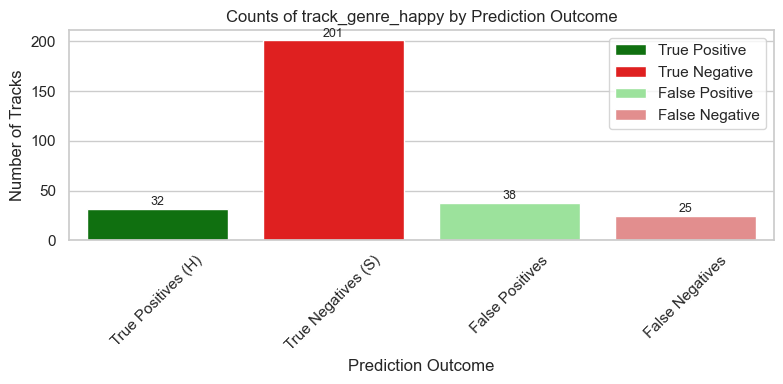

True Positives (H)     32
True Negatives (S)    201
False Positives        38
False Negatives        25
Name: track_genre_happy, dtype: int64


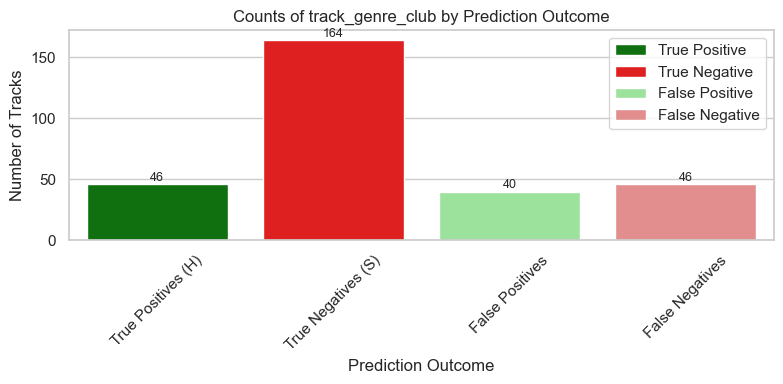

True Positives (H)     46
True Negatives (S)    164
False Positives        40
False Negatives        46
Name: track_genre_club, dtype: int64


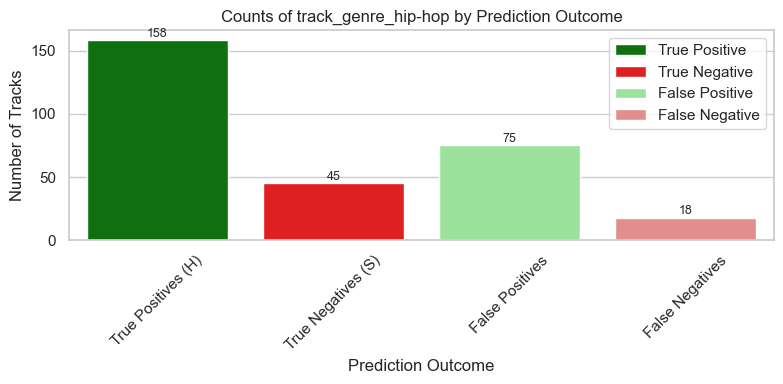

True Positives (H)    158
True Negatives (S)     45
False Positives        75
False Negatives        18
Name: track_genre_hip-hop, dtype: int64


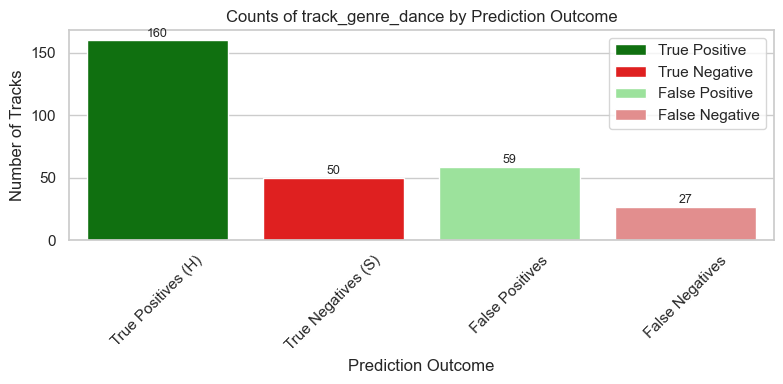

True Positives (H)    160
True Negatives (S)     50
False Positives        59
False Negatives        27
Name: track_genre_dance, dtype: int64


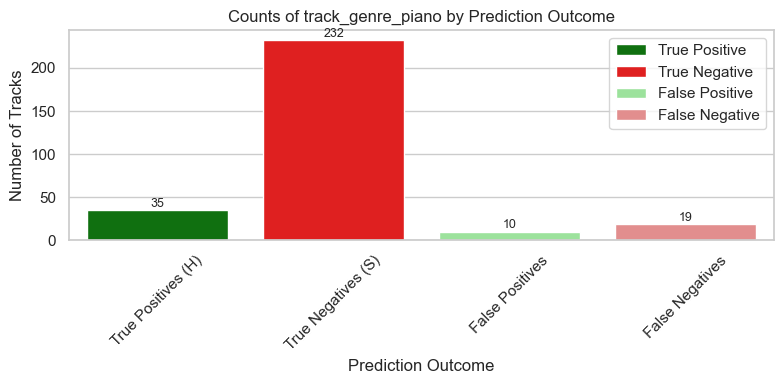

True Positives (H)     35
True Negatives (S)    232
False Positives        10
False Negatives        19
Name: track_genre_piano, dtype: int64


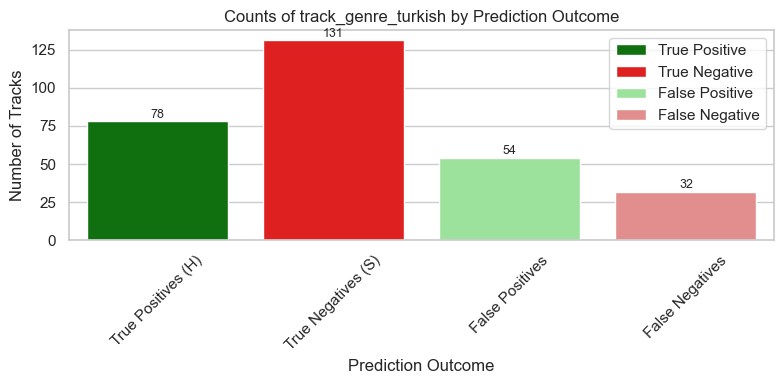

True Positives (H)     78
True Negatives (S)    131
False Positives        54
False Negatives        32
Name: track_genre_turkish, dtype: int64


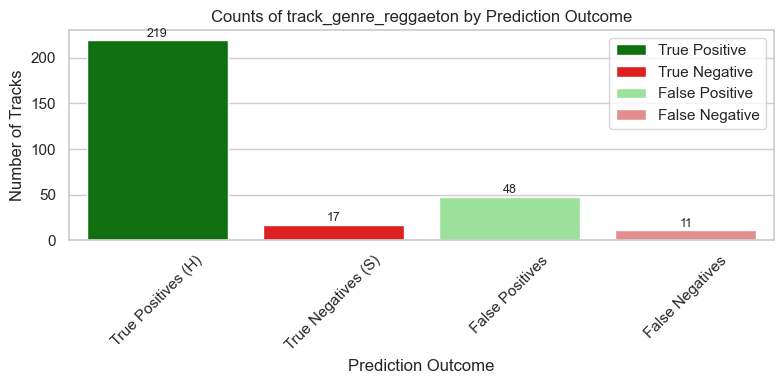

True Positives (H)    219
True Negatives (S)     17
False Positives        48
False Negatives        11
Name: track_genre_reggaeton, dtype: int64


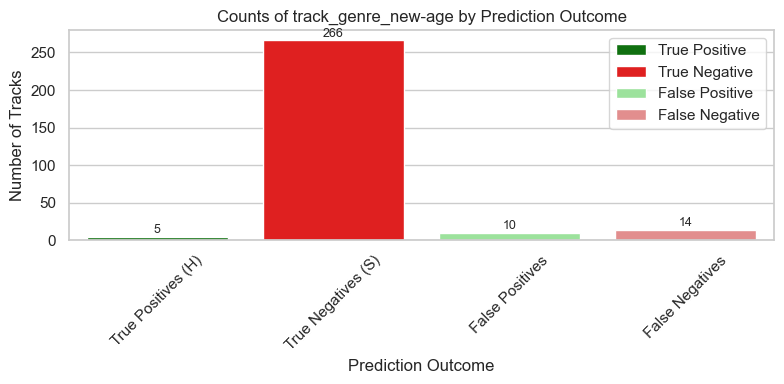

True Positives (H)      5
True Negatives (S)    266
False Positives        10
False Negatives        14
Name: track_genre_new-age, dtype: int64


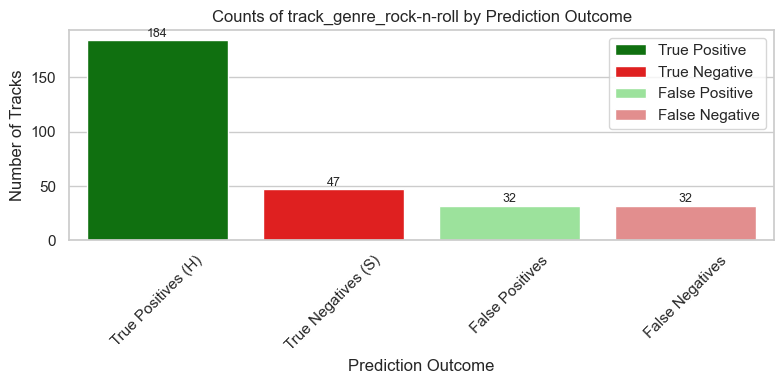

True Positives (H)    184
True Negatives (S)     47
False Positives        32
False Negatives        32
Name: track_genre_rock-n-roll, dtype: int64


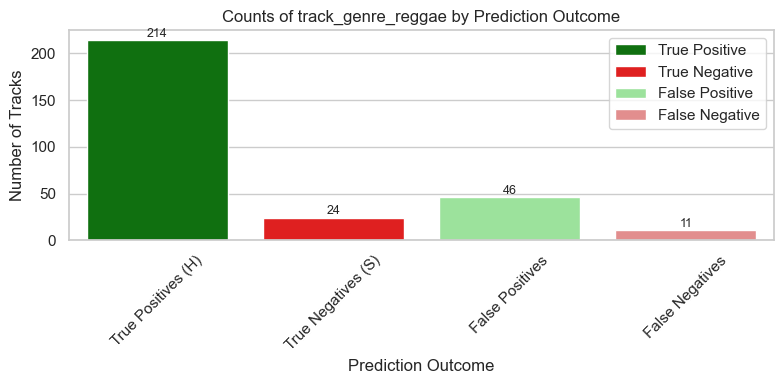

True Positives (H)    214
True Negatives (S)     24
False Positives        46
False Negatives        11
Name: track_genre_reggae, dtype: int64


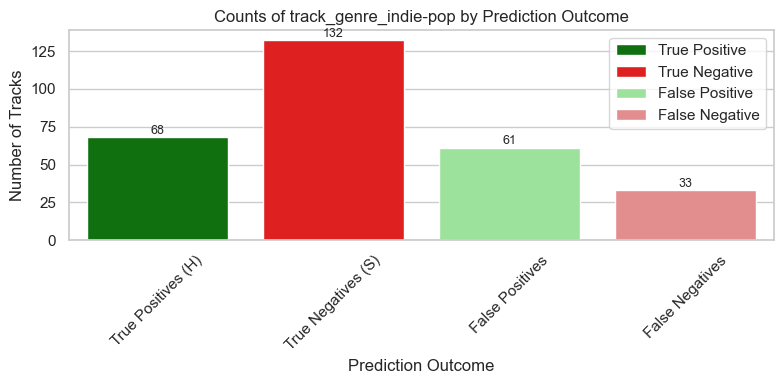

True Positives (H)     68
True Negatives (S)    132
False Positives        61
False Negatives        33
Name: track_genre_indie-pop, dtype: int64


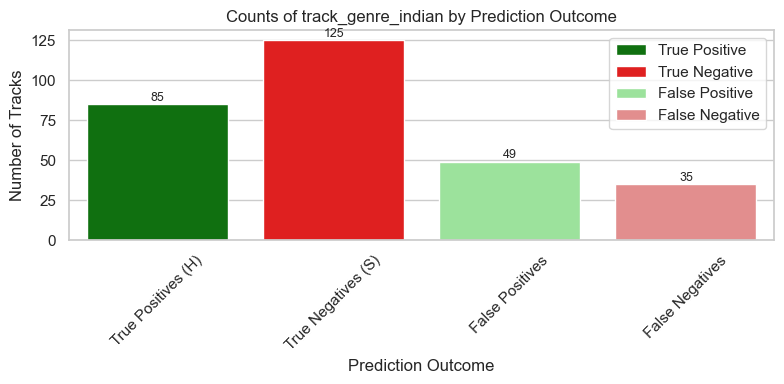

True Positives (H)     85
True Negatives (S)    125
False Positives        49
False Negatives        35
Name: track_genre_indian, dtype: int64


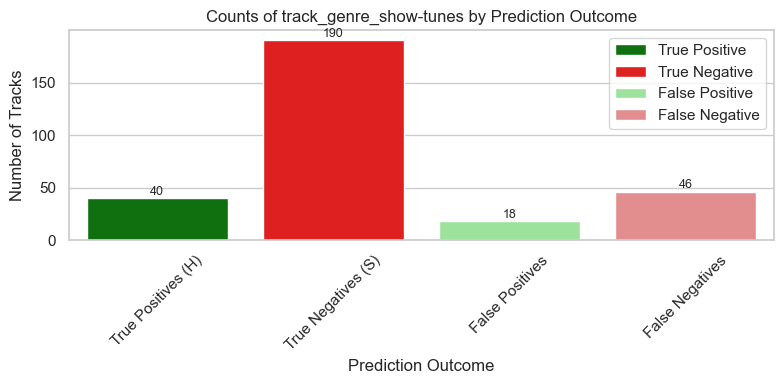

True Positives (H)     40
True Negatives (S)    190
False Positives        18
False Negatives        46
Name: track_genre_show-tunes, dtype: int64


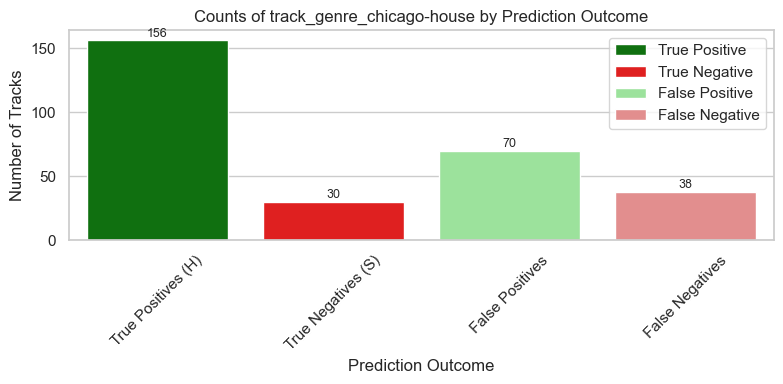

True Positives (H)    156
True Negatives (S)     30
False Positives        70
False Negatives        38
Name: track_genre_chicago-house, dtype: int64


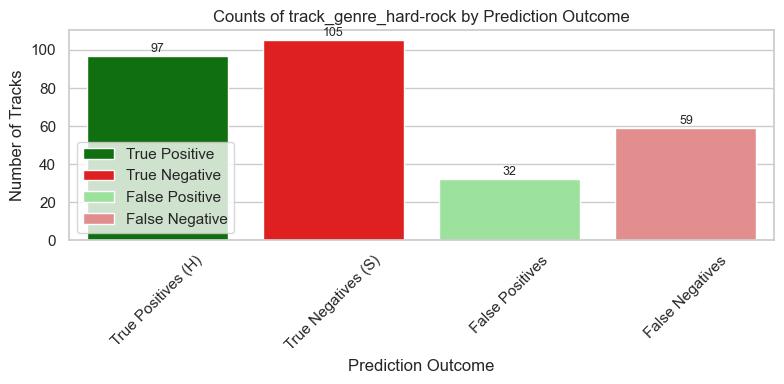

True Positives (H)     97
True Negatives (S)    105
False Positives        32
False Negatives        59
Name: track_genre_hard-rock, dtype: int64


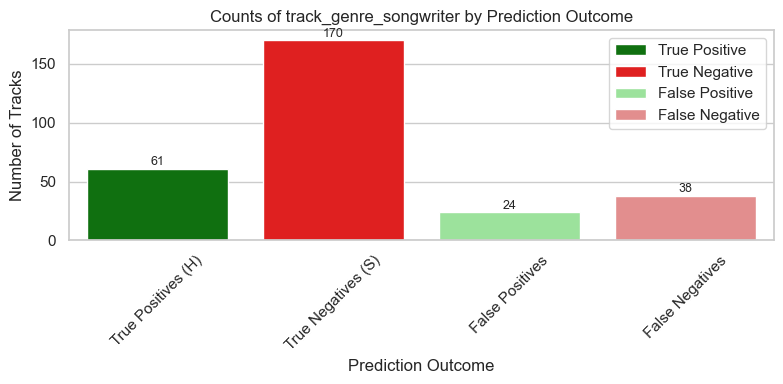

True Positives (H)     61
True Negatives (S)    170
False Positives        24
False Negatives        38
Name: track_genre_songwriter, dtype: int64


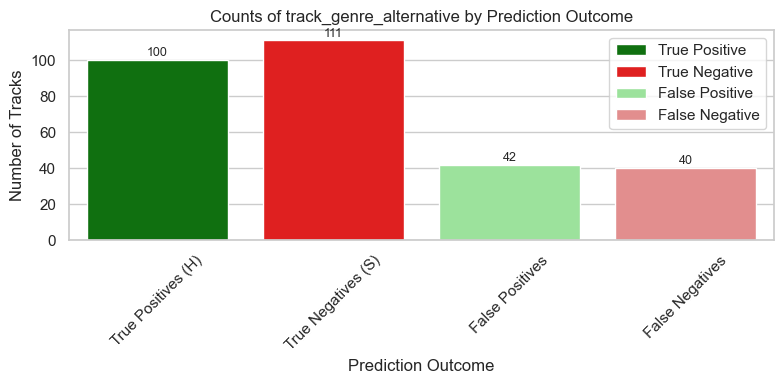

True Positives (H)    100
True Negatives (S)    111
False Positives        42
False Negatives        40
Name: track_genre_alternative, dtype: int64


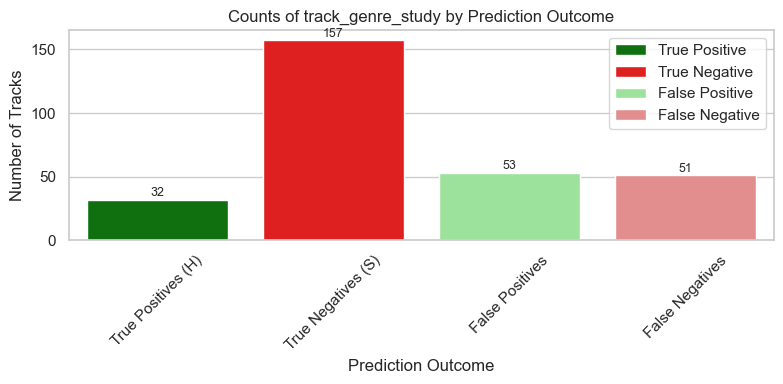

True Positives (H)     32
True Negatives (S)    157
False Positives        53
False Negatives        51
Name: track_genre_study, dtype: int64


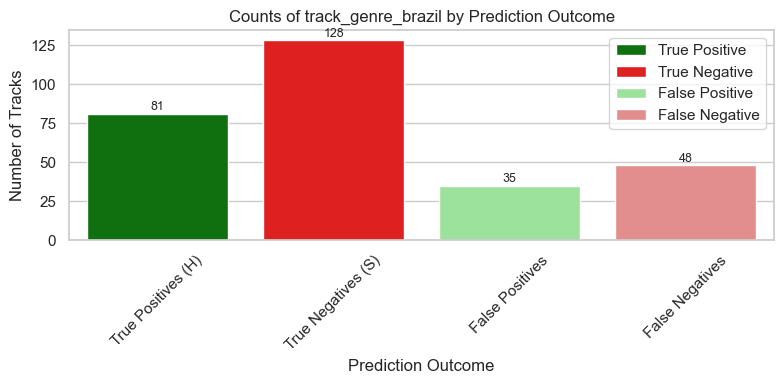

True Positives (H)     81
True Negatives (S)    128
False Positives        35
False Negatives        48
Name: track_genre_brazil, dtype: int64


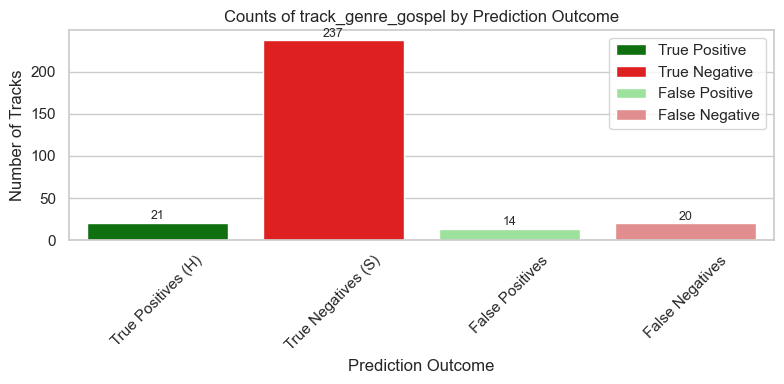

True Positives (H)     21
True Negatives (S)    237
False Positives        14
False Negatives        20
Name: track_genre_gospel, dtype: int64


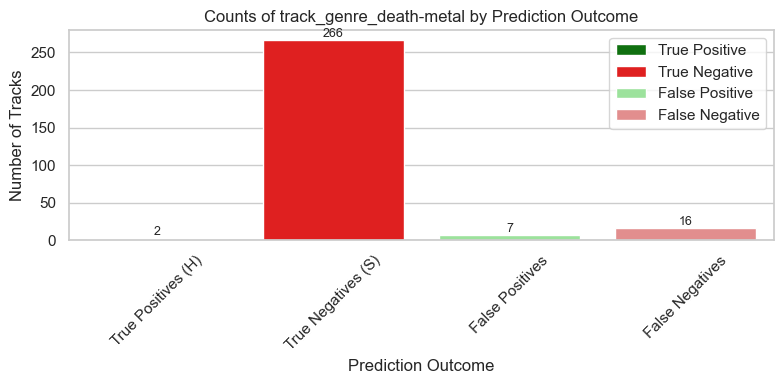

True Positives (H)      2
True Negatives (S)    266
False Positives         7
False Negatives        16
Name: track_genre_death-metal, dtype: int64


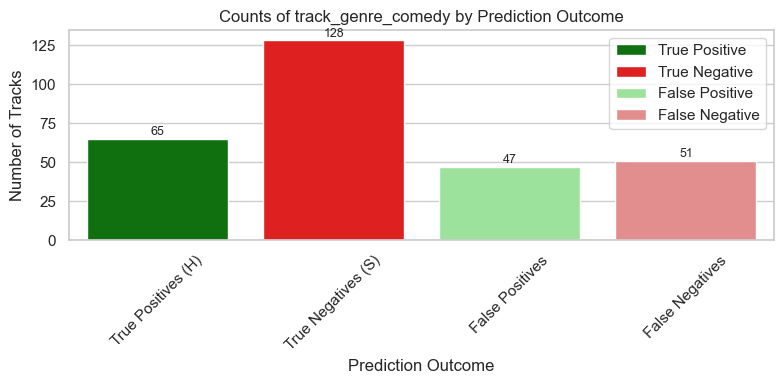

True Positives (H)     65
True Negatives (S)    128
False Positives        47
False Negatives        51
Name: track_genre_comedy, dtype: int64


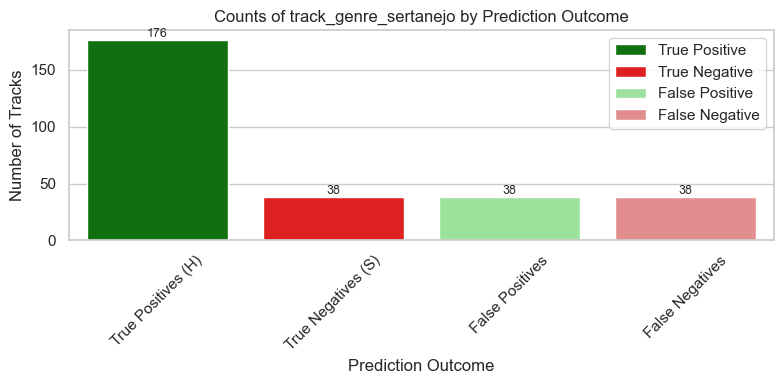

True Positives (H)    176
True Negatives (S)     38
False Positives        38
False Negatives        38
Name: track_genre_sertanejo, dtype: int64


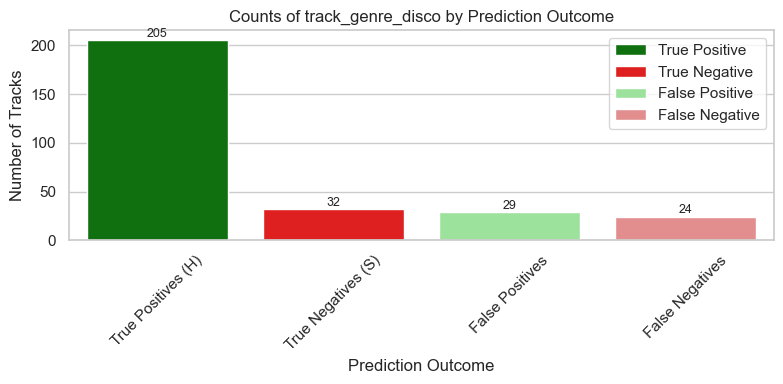

True Positives (H)    205
True Negatives (S)     32
False Positives        29
False Negatives        24
Name: track_genre_disco, dtype: int64


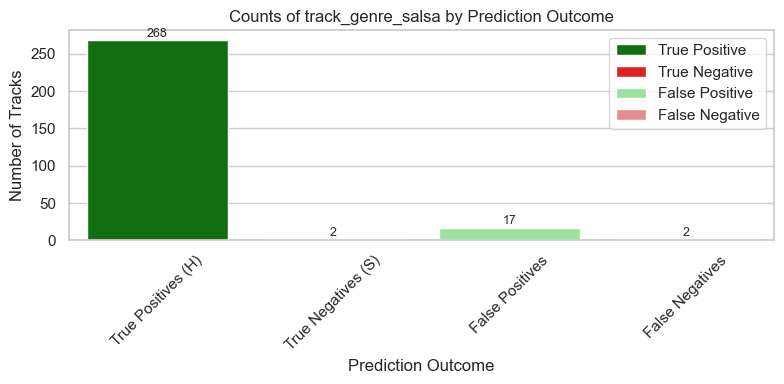

True Positives (H)    268
True Negatives (S)      2
False Positives        17
False Negatives         2
Name: track_genre_salsa, dtype: int64


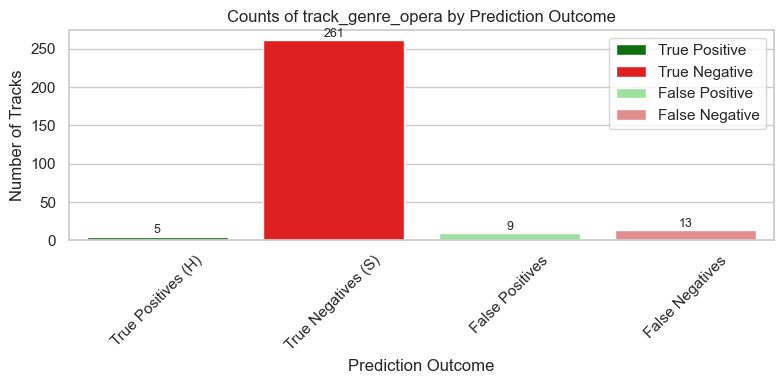

True Positives (H)      5
True Negatives (S)    261
False Positives         9
False Negatives        13
Name: track_genre_opera, dtype: int64


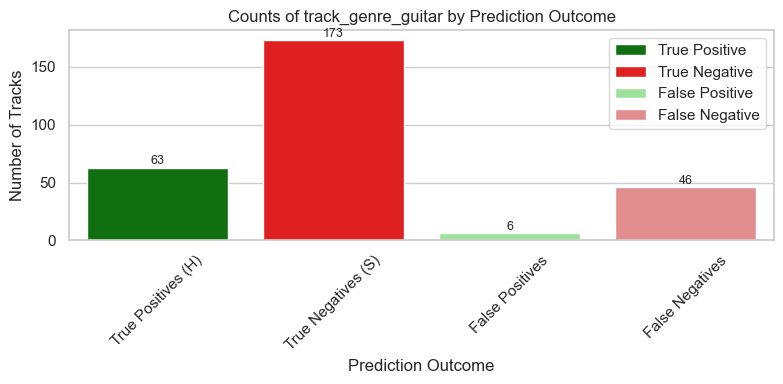

True Positives (H)     63
True Negatives (S)    173
False Positives         6
False Negatives        46
Name: track_genre_guitar, dtype: int64


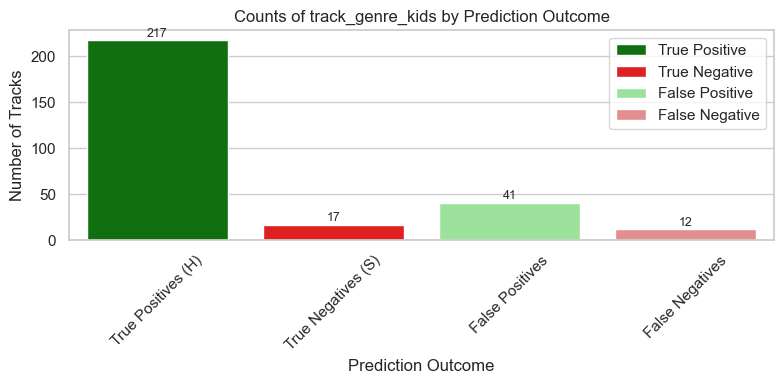

True Positives (H)    217
True Negatives (S)     17
False Positives        41
False Negatives        12
Name: track_genre_kids, dtype: int64


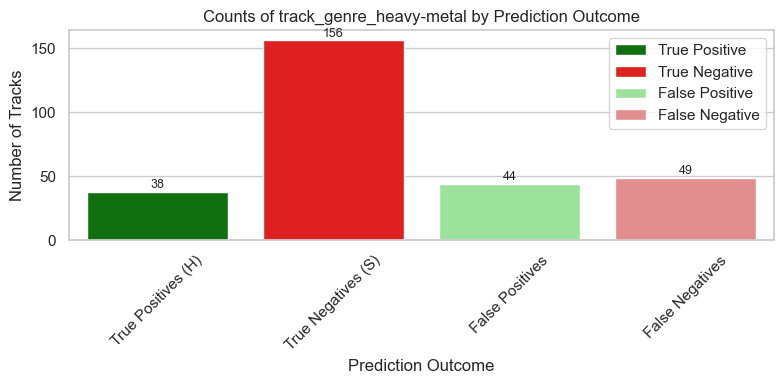

True Positives (H)     38
True Negatives (S)    156
False Positives        44
False Negatives        49
Name: track_genre_heavy-metal, dtype: int64


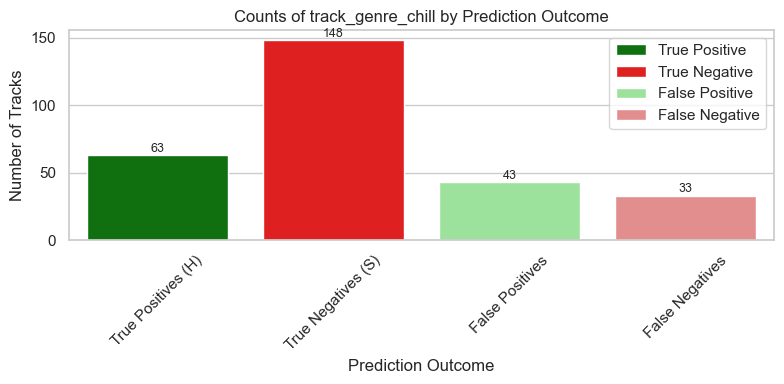

True Positives (H)     63
True Negatives (S)    148
False Positives        43
False Negatives        33
Name: track_genre_chill, dtype: int64


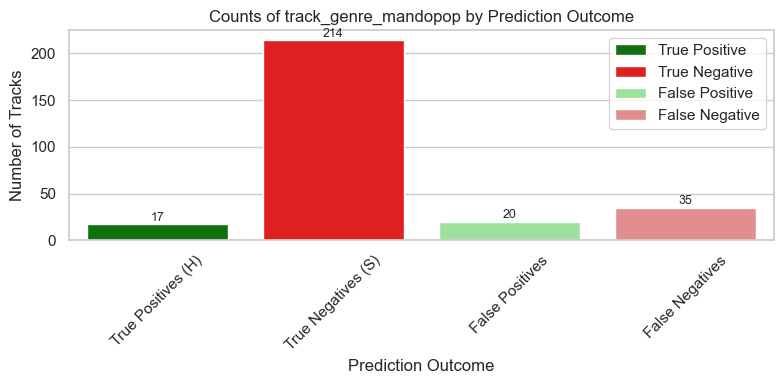

True Positives (H)     17
True Negatives (S)    214
False Positives        20
False Negatives        35
Name: track_genre_mandopop, dtype: int64


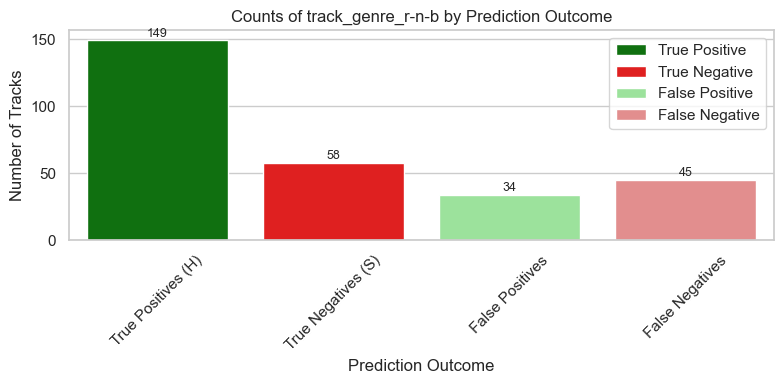

True Positives (H)    149
True Negatives (S)     58
False Positives        34
False Negatives        45
Name: track_genre_r-n-b, dtype: int64


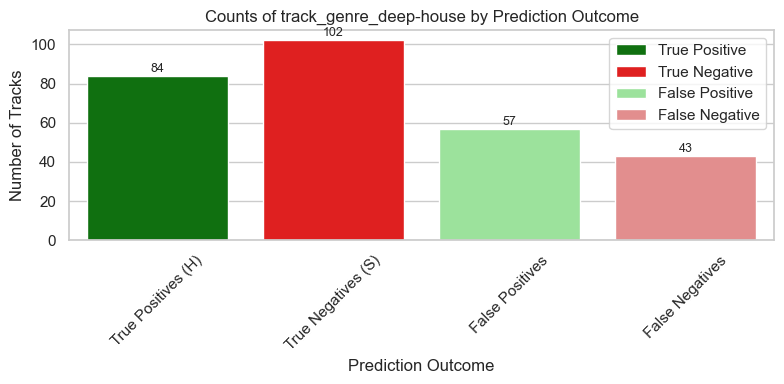

True Positives (H)     84
True Negatives (S)    102
False Positives        57
False Negatives        43
Name: track_genre_deep-house, dtype: int64


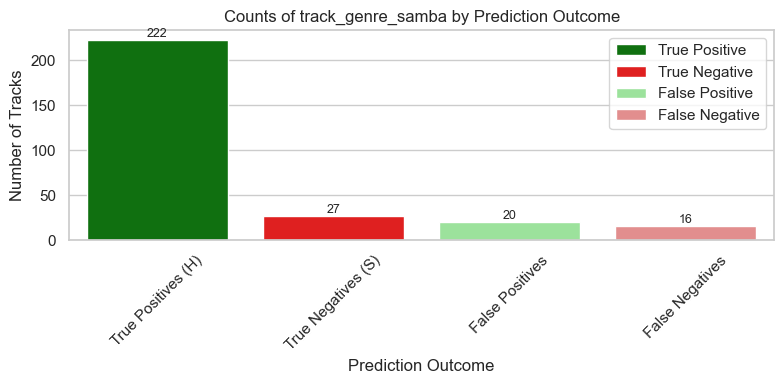

True Positives (H)    222
True Negatives (S)     27
False Positives        20
False Negatives        16
Name: track_genre_samba, dtype: int64


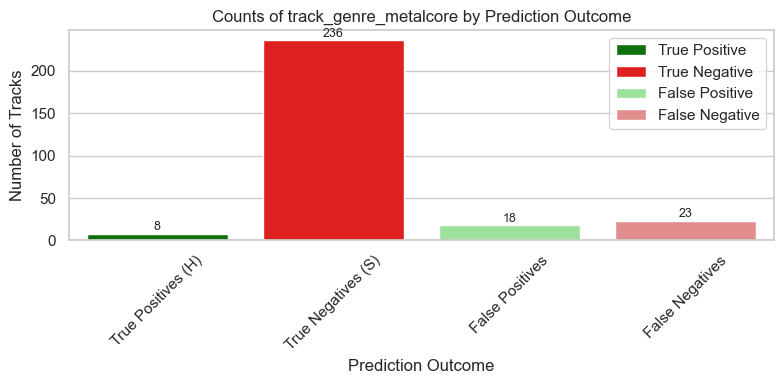

True Positives (H)      8
True Negatives (S)    236
False Positives        18
False Negatives        23
Name: track_genre_metalcore, dtype: int64


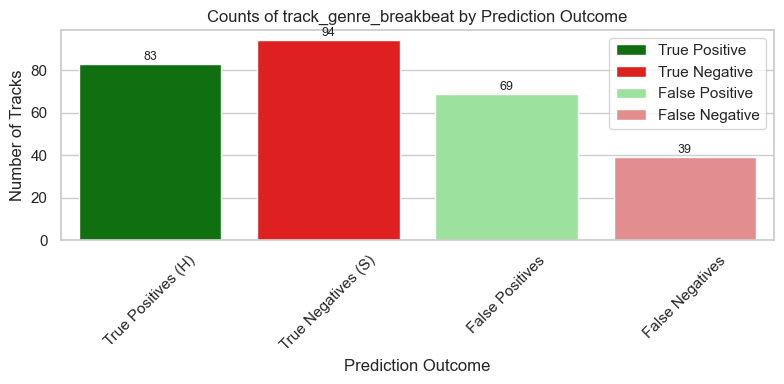

True Positives (H)    83
True Negatives (S)    94
False Positives       69
False Negatives       39
Name: track_genre_breakbeat, dtype: int64


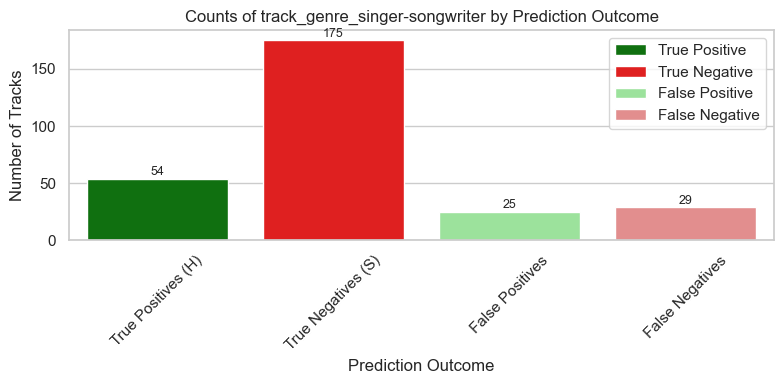

True Positives (H)     54
True Negatives (S)    175
False Positives        25
False Negatives        29
Name: track_genre_singer-songwriter, dtype: int64


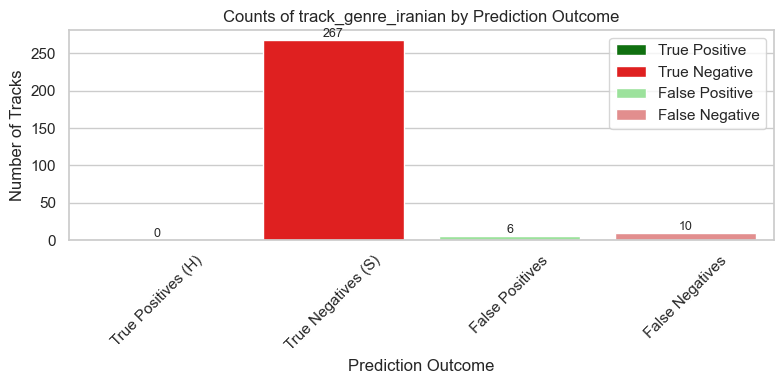

True Positives (H)      0
True Negatives (S)    267
False Positives         6
False Negatives        10
Name: track_genre_iranian, dtype: int64


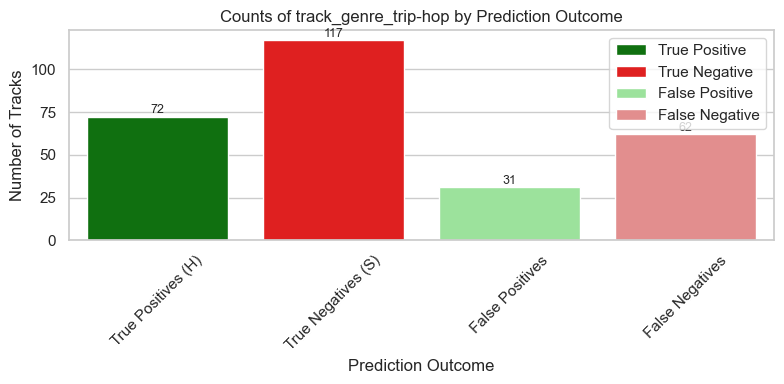

True Positives (H)     72
True Negatives (S)    117
False Positives        31
False Negatives        62
Name: track_genre_trip-hop, dtype: int64


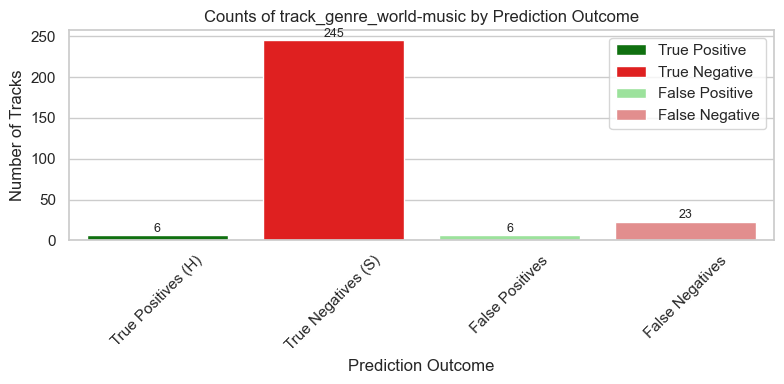

True Positives (H)      6
True Negatives (S)    245
False Positives         6
False Negatives        23
Name: track_genre_world-music, dtype: int64


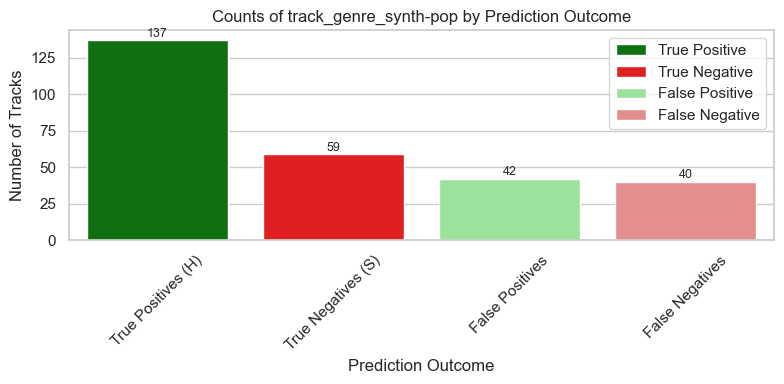

True Positives (H)    137
True Negatives (S)     59
False Positives        42
False Negatives        40
Name: track_genre_synth-pop, dtype: int64


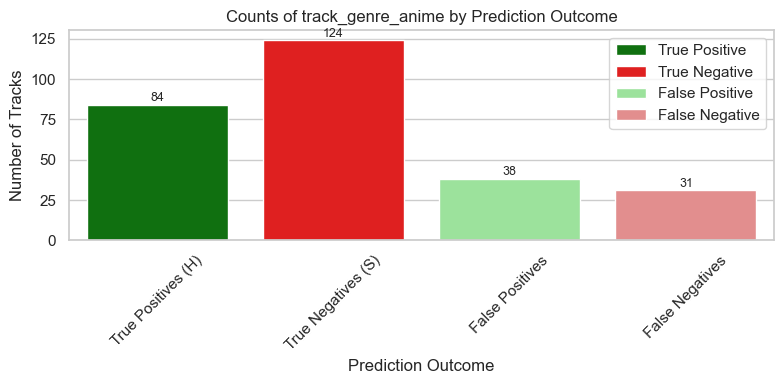

True Positives (H)     84
True Negatives (S)    124
False Positives        38
False Negatives        31
Name: track_genre_anime, dtype: int64


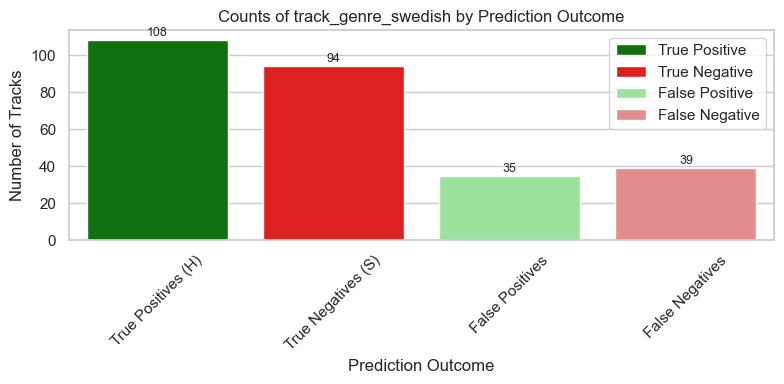

True Positives (H)    108
True Negatives (S)     94
False Positives        35
False Negatives        39
Name: track_genre_swedish, dtype: int64


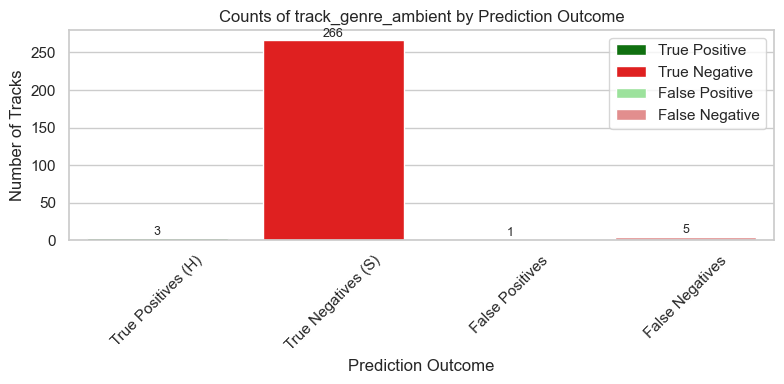

True Positives (H)      3
True Negatives (S)    266
False Positives         1
False Negatives         5
Name: track_genre_ambient, dtype: int64


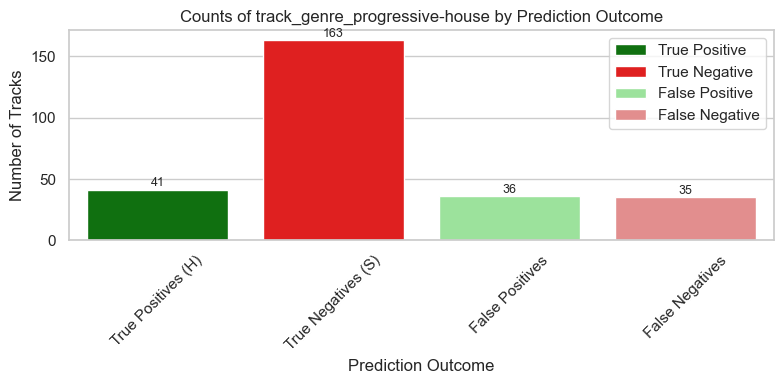

True Positives (H)     41
True Negatives (S)    163
False Positives        36
False Negatives        35
Name: track_genre_progressive-house, dtype: int64


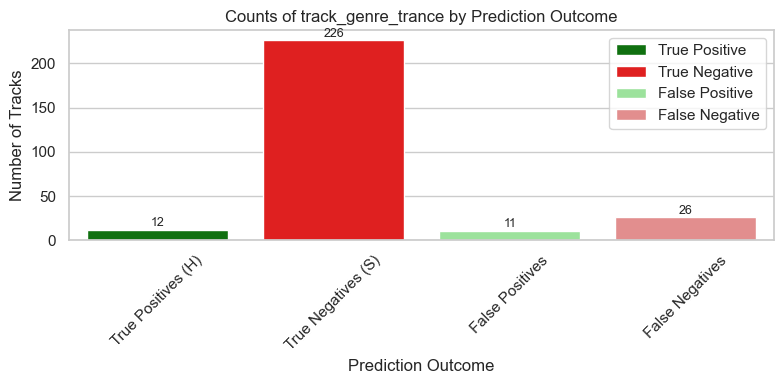

True Positives (H)     12
True Negatives (S)    226
False Positives        11
False Negatives        26
Name: track_genre_trance, dtype: int64


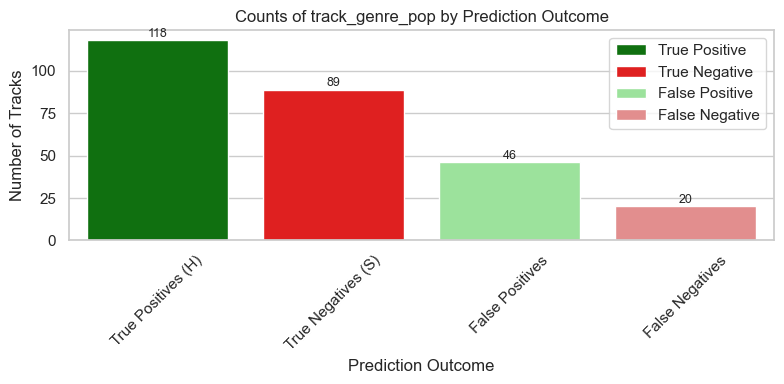

True Positives (H)    118
True Negatives (S)     89
False Positives        46
False Negatives        20
Name: track_genre_pop, dtype: int64


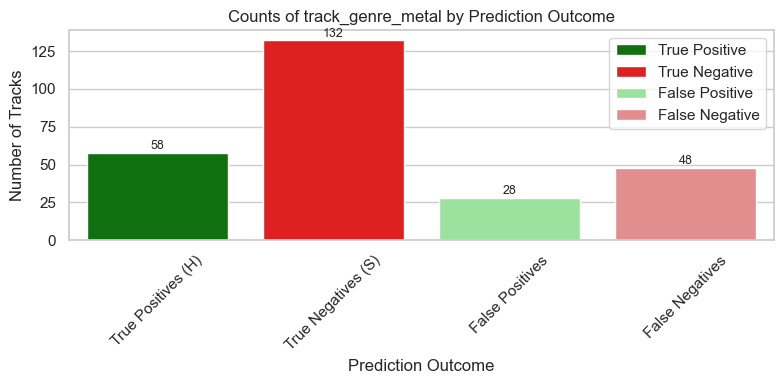

True Positives (H)     58
True Negatives (S)    132
False Positives        28
False Negatives        48
Name: track_genre_metal, dtype: int64


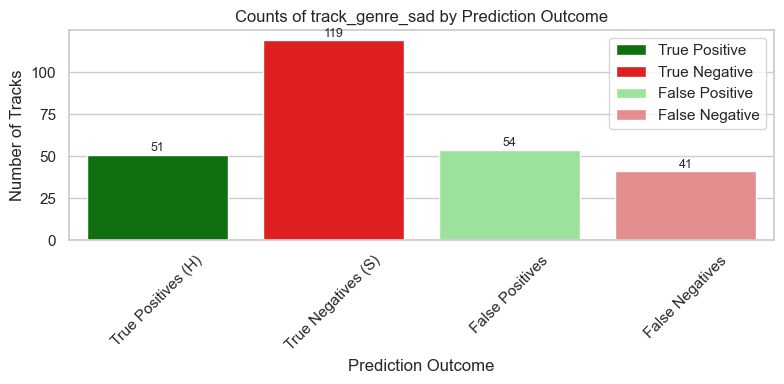

True Positives (H)     51
True Negatives (S)    119
False Positives        54
False Negatives        41
Name: track_genre_sad, dtype: int64


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: prettier style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# --- Genre Counts per Prediction Outcome ---

# Ensure genre columns are all 0 or 1
genre_cols = [col for col in df.columns if col.startswith("track_genre")]


# Define the prediction outcome groups
groups = {
    "True Positives (H)": true_positives,
    "True Negatives (S)": true_negatives,
    "False Positives": false_positives,
    "False Negatives": false_negatives,
}


# Count genres per group
genre_counts = {
    group_name: (group_df[genre_cols]).astype(int).sum()
    for group_name, group_df in groups.items()
}


# Create a DataFrame
genre_counts_df = pd.DataFrame(genre_counts).T  # Outcomes as rows
# genre_counts_df.to_csv('output.csv', index=False)


top_genres = genre_counts_df.sum(axis=0).sort_values(ascending=False).index
# top_genres = genre_counts_df.sum(axis=0).sort_values(ascending=False).head(20).index


# Plot barplot for each genre
for genre in top_genres:
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(
        x=genre_counts_df.index,
        y=genre_counts_df[genre].values,
        hue=["True Positive", "True Negative", "False Positive", "False Negative"],
        palette=["green", "red", "lightgreen", "lightcoral"],
    )

    # Add value labels above bars
    for i, value in enumerate(genre_counts_df[genre].values):
        ax.text(i, value + 0.5, str(int(value)), ha="center", va="bottom", fontsize=9)

    plt.title(f"Counts of {genre} by Prediction Outcome")
    plt.ylabel("Number of Tracks")
    plt.xlabel("Prediction Outcome")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(genre_counts_df[genre])